In [1]:
import pandas as pd
import numpy as np
%config inlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
%matplotlib inline


# plt.rcParams['font.family'] = 'Helvetica'


In [2]:
file_path = "/data/work/shared/safe_data/sleep_skew/skew_project_start_oct_2022/"
phone_sample = pd.read_csv(file_path+"phone_data_s60.csv")
phone_sample['day_label_dt'] = pd.to_datetime(phone_sample['day_label'],unit='d')

activity_sample = pd.read_csv(file_path+"steps_data_s60.csv")
activity_sample['day_label_dt'] = pd.to_datetime(activity_sample['day_label'],unit='d')


'''Getting the sleeping info of the chosen user from another file'''
sleep_sample = pd.read_csv(file_path+"sleep_skew_data_w_demographics.csv")
sleep_sample['sleep_duration_round'] = np.round(sleep_sample['sleep_duration']/3600,2)
sleep_sample['sleep_start'] = pd.to_datetime(sleep_sample['day_label'],unit='d')
sleep_sample['sleep_start_shift'] = np.where(sleep_sample['start_time_num_round'] >= 12,
                                            sleep_sample['sleep_start'],
                                             sleep_sample['sleep_start']-pd.to_timedelta(1,unit='d')
                                            )
sleep_sample['day_of_week'] = sleep_sample['sleep_start_shift'].dt.day_name()
sleep_sample['weekend'] = np.where(sleep_sample['day_of_week'].isin(['Friday','Saturday']),1,0)

sleep_sample['start_time_num_round_25'] = ((sleep_sample['start_time_num_round']%1)*100/60)+sleep_sample['start_time_num_round'].astype(int)
sleep_sample['end_time_num_round_25'] = ((sleep_sample['end_time_num_round']%1)*100/60)+sleep_sample['end_time_num_round'].astype(int)

'''EXCEPTION HANDLING FOR 24.00 : SHOULD SHOW AS 00.00'''

sleep_sample['start_time_num_round_25'] = round(sleep_sample['start_time_num_round_25']*4)/4
sleep_sample['end_time_num_round_25'] = round(sleep_sample['end_time_num_round_25']*4)/4

sleep_sample['start_time_num_round_25'] = np.where(sleep_sample['start_time_num_round_25']==24,0,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(sleep_sample['end_time_num_round_25']==24,0,sleep_sample['end_time_num_round_25'])

''' EXCEPTION HANDLING FOR SLEEP ONSET BETWEEN 23.45 AND 23.59 : SHOW AS 23.75 '''
sleep_sample['start_time_num_round_25'] = np.where(((sleep_sample['start_time_num_round'] >= 23.45) &
                                                   (sleep_sample['start_time_num_round'] < 24.0)), 23.75,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(((sleep_sample['end_time_num_round'] >= 23.45) &
                                                  (sleep_sample['end_time_num_round'] < 24.0)), 23.75,sleep_sample['end_time_num_round_25']) 



''' 
Defining Naps and shift sleep
If someone sleeps between 11am and 3pm
    - Less than 3 hours : Nap
    - More than 3 hours : Shift worker sleep
'''
sleep_sample['nap'] = np.where(
    ((sleep_sample['sleep_duration_round']<3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)
sleep_sample['shift_sleep'] = np.where(
    ((sleep_sample['sleep_duration_round']>=3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)

'''Deleting shift sleeps'''
sleep_sample = sleep_sample[sleep_sample['shift_sleep'] ==0]

sleep_sample.drop(columns={'gender','age_group','country','weekday','day_label','day_label_shift'},inplace=True)
sleep_sample.sort_values(by=['user_id','sleep_start_shift','sleep_start','start_time_num_round'],inplace=True)
print("Number of rows: ",len(sleep_sample))
print("Unique users: ",len(sleep_sample['user_id'].unique()))
# print("Unique countries: ",len(sleep_sample['country'].unique()))

Number of rows:  30963297
Unique users:  112928


In [3]:
sleep_sample.head(n=2)

,user_id,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,sleep_start,sleep_start_shift,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep
30176662,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Saturday,1,23.40,7.5,28860,8.02,2016-04-02,2016-04-02,23.75,7.75,0,0
30176686,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Sunday,0,0.05,7.1,24840,6.90,2016-04-04,2016-04-03,0.00,7.25,0,0


In [4]:
phone_sample.head(n=2)

,user_id,duration,day_label,start_time_num_round,day_label_dt
0,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,281,17726,23.45,2018-07-14
1,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,56,17538,19.45,2018-01-07


In [5]:
activity_sample.head(n=2)

,user_id,day_label,start_time_num_round,steps,day_label_dt
0,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17129,10.15,63.0,2016-11-24
1,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17390,20.30,1219.0,2017-08-12


## Creating a mapping for the users so that it can be used across the board

In [6]:
'''Identifying the unique users in phone and activity data and excluding customers from analysis who dont have
this data'''
unique_phone_users = phone_sample['user_id'].unique()
unique_activity_users = activity_sample['user_id'].unique()
sleep_sample = sleep_sample[(sleep_sample['user_id'].isin(unique_phone_users)) & 
                            (sleep_sample['user_id'].isin(unique_activity_users))]

print("Count of users in sleep data: ",len(sleep_sample['user_id'].unique()))

'''need to make a mapping between alpha numeric user ids and integer user_ids'''
user_id_mapping = pd.DataFrame(sleep_sample['user_id'].unique()).reset_index()
user_id_mapping.columns=['new_user_id','user_id']
user_id_mapping['new_user_id'] = user_id_mapping['new_user_id']+1
print(np.min(user_id_mapping['new_user_id']),np.max(user_id_mapping['new_user_id']))

def append_userid(df):
    df= df.merge(user_id_mapping,how='left',left_on = 'user_id',right_on='user_id')
    df.drop(columns={'user_id'},inplace=True)
    df.rename(columns={'new_user_id':'user_id'},inplace=True)
    return df
    
sleep_sample = append_userid(sleep_sample)
phone_sample = append_userid(phone_sample)
activity_sample = append_userid(activity_sample)

print("sleep data: ",sleep_sample.columns)
print("phone usage: ",phone_sample.columns)
print("activity: ",activity_sample.columns)


Count of users in sleep data:  3384
1 3384
sleep data:  Index(['day_of_week', 'weekend', 'start_time_num_round', 'end_time_num_round',
       'sleep_duration', 'sleep_duration_round', 'sleep_start',
       'sleep_start_shift', 'start_time_num_round_25', 'end_time_num_round_25',
       'nap', 'shift_sleep', 'user_id'],
      dtype='object')
phone usage:  Index(['duration', 'day_label', 'start_time_num_round', 'day_label_dt',
       'user_id'],
      dtype='object')
activity:  Index(['day_label', 'start_time_num_round', 'steps', 'day_label_dt',
       'user_id'],
      dtype='object')


In [7]:
sleep_sample.head(n=2)

,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,sleep_start,sleep_start_shift,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep,user_id
0,Saturday,1,16.05,19.15,11520,3.20,2015-07-04,2015-07-04,16.0,19.25,0,0,1
1,Saturday,1,8.55,18.45,35400,9.83,2015-07-05,2015-07-04,9.0,18.75,0,0,1


In [8]:
phone_sample.head(n=2)

,duration,day_label,start_time_num_round,day_label_dt,user_id
0,281,17726,23.45,2018-07-14,28
1,56,17538,19.45,2018-01-07,28


In [9]:
activity_sample.head(n=2)

,day_label,start_time_num_round,steps,day_label_dt,user_id
0,17129,10.15,63.0,2016-11-24,77.0
1,17390,20.30,1219.0,2017-08-12,77.0


## Calculating sleep duration median and skew

In [10]:
_skew = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()
_skew = _skew.reset_index()
_skew.rename(columns={'sleep_duration_round':'sleep_duration_skew'},inplace=True)

_avg = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').mean()
_avg = _avg.reset_index()
_avg.rename(columns={'sleep_duration_round':'sleep_duration_avg'},inplace=True)

_med = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').median()
_med = _med.reset_index()
_med.rename(columns = {'sleep_duration_round':'sleep_duration_median'},inplace=True)
_skew = _skew.merge(_med,how='left', left_on='user_id',right_on='user_id')
_skew['sleep_dur_median_bucket']= np.round(_skew['sleep_duration_median']*2)/2
_skew.sort_values(by='sleep_duration_skew',ascending=False, inplace=True)

_skew = _skew.merge(_avg, how='left',left_on = 'user_id',right_on='user_id')
_skew['skew_2'] = _skew['sleep_duration_median']- _skew['sleep_duration_avg']
_skew

,user_id,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg,skew_2
0,1211,2.319075,6.73,6.5,6.937147,-0.207147
1,1182,1.966655,5.77,6.0,6.052583,-0.282583
2,2039,1.953479,5.32,5.5,5.736361,-0.416361
3,1901,1.937355,5.43,5.5,6.015566,-0.585566
4,67,1.808291,6.15,6.0,6.394125,-0.244125
...,...,...,...,...,...,...
3379,2070,-2.659640,6.90,7.0,6.827136,0.072864
3380,733,-2.727773,8.57,8.5,8.444496,0.125504
3381,2798,-2.840200,6.88,7.0,6.715773,0.164227
3382,2567,-3.460372,7.72,7.5,7.602108,0.117892


## Identifying streaks of sleep ( not just the longest one)

In [12]:
sleep_sample['lag_sleep_start_shift'] = sleep_sample['sleep_start_shift'].shift(1) #changed from -1
sleep_sample['lag_user_id'] = sleep_sample['user_id'].shift(1) #changed from -1

conditions = [
    ((sleep_sample['sleep_start_shift']-sleep_sample['lag_sleep_start_shift']).dt.days <= 1) &
    (sleep_sample['lag_user_id'] == sleep_sample['user_id']) & (sleep_sample['nap'] ==0)] # change from ==1,switched around vars in subtraction
choices = [1]
sleep_sample['continuous_data_sleep'] = np.select(conditions,choices)

s = sleep_sample['continuous_data_sleep'].eq(True)
sleep_sample['count'] = (sleep_sample.groupby(['user_id',s.ne(s.shift()).cumsum()])
                         .cumcount()
                         .add(1)
                        )
sleep_sample_ContOnly = sleep_sample[sleep_sample['continuous_data_sleep']==1]

sleep_sample_ContOnly['ContNapCount'] = sleep_sample_ContOnly.groupby(['user_id',s.ne(s.shift()).cumsum()])['nap'].cumsum()
#keep only first records and records where count > 7
sleep_sample_ContOnly = sleep_sample_ContOnly[(sleep_sample_ContOnly['count']==1) | (sleep_sample_ContOnly['count']>30)]
len(sleep_sample_ContOnly)

/tmp/ipykernel_3978959/4030196827.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_sample_ContOnly['ContNapCount'] = sleep_sample_ContOnly.groupby(['user_id',s.ne(s.shift()).cumsum()])['nap'].cumsum()


904449

In [13]:
sleep_sample_ContOnly['count'].unique()

array([   1,   31,   32, ..., 1056, 1057, 1058])

In [14]:
SleepContInnings = []
for i in range(2,len(sleep_sample_ContOnly)):
    if sleep_sample_ContOnly['count'].iloc[i] == 1:
        SleepContInnings.append([sleep_sample_ContOnly['user_id'].iloc[i-1],
                                 sleep_sample_ContOnly['sleep_start_shift'].iloc[i-1],
                                 sleep_sample_ContOnly['count'].iloc[i-1],
                                sleep_sample_ContOnly['ContNapCount'].iloc[i-1]])
print(len(SleepContInnings))
SleepContInnings_df = pd.DataFrame(SleepContInnings,columns =['user_id','sleep_start_shift','count','ContNapCount'])
SleepContInnings_df = SleepContInnings_df[SleepContInnings_df['count']>1]
SleepContInnings_df['sleep_streak_start_date']=SleepContInnings_df['sleep_start_shift']-pd.to_timedelta(SleepContInnings_df['count']-1,unit='d')

SleepContInnings_df = SleepContInnings_df.merge(_skew,how='left',left_on='user_id',right_on='user_id')
SleepContInnings_df.head()

91635


,user_id,sleep_start_shift,count,ContNapCount,sleep_streak_start_date,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg,skew_2
0,1,2015-12-19,46,0,2015-11-04,0.198394,6.225,6.0,6.452320,-0.227320
1,1,2016-02-25,48,0,2016-01-09,0.198394,6.225,6.0,6.452320,-0.227320
2,2,2017-03-31,76,0,2017-01-15,-0.480549,6.970,7.0,6.904434,0.065566
3,2,2017-06-02,61,0,2017-04-03,-0.480549,6.970,7.0,6.904434,0.065566
4,2,2017-07-18,44,0,2017-06-05,-0.480549,6.970,7.0,6.904434,0.065566


In [15]:
SleepContInnings_df[SleepContInnings_df['user_id']==1104]

,user_id,sleep_start_shift,count,ContNapCount,sleep_streak_start_date,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg,skew_2
5699,1104,2015-12-29,72,0,2015-10-19,1.565386,4.37,4.5,4.589294,-0.219294
5700,1104,2016-03-28,33,0,2016-02-25,1.565386,4.37,4.5,4.589294,-0.219294
5701,1104,2016-05-04,35,0,2016-03-31,1.565386,4.37,4.5,4.589294,-0.219294
5702,1104,2016-07-13,46,0,2016-05-29,1.565386,4.37,4.5,4.589294,-0.219294
5703,1104,2016-11-03,89,0,2016-08-07,1.565386,4.37,4.5,4.589294,-0.219294
5704,1104,2017-03-05,44,0,2017-01-21,1.565386,4.37,4.5,4.589294,-0.219294
5705,1104,2017-04-28,48,0,2017-03-12,1.565386,4.37,4.5,4.589294,-0.219294
5706,1104,2017-06-09,36,0,2017-05-05,1.565386,4.37,4.5,4.589294,-0.219294
5707,1104,2018-01-04,138,0,2017-08-20,1.565386,4.37,4.5,4.589294,-0.219294
5708,1104,2018-03-22,75,0,2018-01-07,1.565386,4.37,4.5,4.589294,-0.219294


## Calculating streaks of phone usage

In [16]:
phone_user_day_rollup = phone_sample[['user_id','day_label','duration']].groupby(['user_id','day_label']).sum().reset_index()

'''will include only those days where phone viewing per day is more than 60 minutes'''
phone_user_day_rollup = phone_user_day_rollup[phone_user_day_rollup['duration']>=3600]
phone_user_day_rollup.sort_values(by=['user_id','day_label'],inplace=True)
phone_user_day_rollup.head()

,user_id,day_label,duration
0,1,16587,5234
1,1,16588,10469
2,1,16589,8829
3,1,16590,11973
4,1,16591,16360


In [17]:
phone_user_day_rollup['lag_day_label'] = phone_user_day_rollup['day_label'].shift(1) #changed from -1
phone_user_day_rollup['lag_user_id'] = phone_user_day_rollup['user_id'].shift(1) #changed from -1

conditions = [
    ((phone_user_day_rollup['day_label']-phone_user_day_rollup['lag_day_label']) <= 1) &
    (phone_user_day_rollup['lag_user_id'] == phone_user_day_rollup['user_id'])] # change from ==1,switched around vars in subtraction
choices = [1]
phone_user_day_rollup['continuous_data_phone'] = np.select(conditions,choices)

s = phone_user_day_rollup['continuous_data_phone'].eq(True)
phone_user_day_rollup['count'] = (phone_user_day_rollup.groupby(['user_id',s.ne(s.shift()).cumsum()])
                         .cumcount()
                         .add(1)
                        )
phone_sample_ContOnly = phone_user_day_rollup[phone_user_day_rollup['continuous_data_phone']==1]

len(phone_sample_ContOnly)

1375763

In [18]:
PhoneContInnings = []
for i in range(2,len(phone_sample_ContOnly)):
    if phone_sample_ContOnly['count'].iloc[i] == 1:
        PhoneContInnings.append([phone_sample_ContOnly['user_id'].iloc[i-1],
                                 phone_sample_ContOnly['day_label'].iloc[i-1],
                                 phone_sample_ContOnly['count'].iloc[i-1]])
print(len(PhoneContInnings))
PhoneContInnings_df = pd.DataFrame(PhoneContInnings,columns =['user_id','day_label','count'])
PhoneContInnings_df = PhoneContInnings_df[PhoneContInnings_df['count']>1]
PhoneContInnings_df['day_label_dt']= pd.to_datetime(PhoneContInnings_df['day_label'],unit='d')
PhoneContInnings_df['phone_streak_start_date']=PhoneContInnings_df['day_label_dt']-pd.to_timedelta(PhoneContInnings_df['count']-1,unit='d')
PhoneContInnings_df.rename(columns={'day_label_dt':'phone_streak_end_date'},inplace=True)

PhoneContInnings_df.head()

100183


,user_id,day_label,count,phone_streak_end_date,phone_streak_start_date
0,1,16641,54,2015-07-25,2015-06-02
1,1,16698,55,2015-09-20,2015-07-28
2,1,16874,174,2016-03-14,2015-09-23
4,1,16951,72,2016-05-30,2016-03-20
6,1,16974,13,2016-06-22,2016-06-10


## Calculating streaks of activity

In [19]:
activity_user_day_rollup = activity_sample[['user_id','day_label','steps']].groupby(['user_id','day_label']).sum().reset_index()

'''will include only those days where steps per day is more than 1000'''
activity_user_day_rollup = activity_user_day_rollup[activity_user_day_rollup['steps']>=1000]
activity_user_day_rollup.sort_values(by=['user_id','day_label'],inplace=True)
activity_user_day_rollup.head()

,user_id,day_label,steps
0,1.0,16587,2340.0
1,1.0,16588,6916.0
2,1.0,16589,6446.0
3,1.0,16590,7285.0
4,1.0,16591,6822.0


In [20]:
activity_user_day_rollup['lag_day_label'] = activity_user_day_rollup['day_label'].shift(1) #changed from -1
activity_user_day_rollup['lag_user_id'] = activity_user_day_rollup['user_id'].shift(1) #changed from -1

conditions = [
    ((activity_user_day_rollup['day_label']-activity_user_day_rollup['lag_day_label']) <= 1) &
    (activity_user_day_rollup['lag_user_id'] == activity_user_day_rollup['user_id'])] # change from ==1,switched around vars in subtraction
choices = [1]
activity_user_day_rollup['continuous_data_activity'] = np.select(conditions,choices)

s = activity_user_day_rollup['continuous_data_activity'].eq(True)
activity_user_day_rollup['count'] = (activity_user_day_rollup.groupby(['user_id',s.ne(s.shift()).cumsum()])
                         .cumcount()
                         .add(1)
                        )
activity_sample_ContOnly = activity_user_day_rollup[activity_user_day_rollup['continuous_data_activity']==1]

len(activity_sample_ContOnly)


1995637

In [21]:
ActivityContInnings = []
for i in range(2,len(activity_sample_ContOnly)):
    if activity_sample_ContOnly['count'].iloc[i] == 1:
        ActivityContInnings.append([activity_sample_ContOnly['user_id'].iloc[i-1],
                                 activity_sample_ContOnly['day_label'].iloc[i-1],
                                 activity_sample_ContOnly['count'].iloc[i-1]])
print(len(ActivityContInnings))
ActivityContInnings_df = pd.DataFrame(ActivityContInnings,columns =['user_id','day_label','count'])
ActivityContInnings_df = ActivityContInnings_df[ActivityContInnings_df['count']>1]
ActivityContInnings_df['day_label_dt']= pd.to_datetime(ActivityContInnings_df['day_label'],unit='d')
ActivityContInnings_df['activity_streak_start_date']=ActivityContInnings_df['day_label_dt']-pd.to_timedelta(ActivityContInnings_df['count']-1,unit='d')
ActivityContInnings_df.rename(columns={'day_label_dt':'activity_streak_end_date'},inplace=True)

ActivityContInnings_df.head()

180504


,user_id,day_label,count,activity_streak_end_date,activity_streak_start_date
0,1.0,16699,112,2015-09-21,2015-06-02
1,1.0,16740,39,2015-11-01,2015-09-24
3,1.0,16780,2,2015-12-11,2015-12-10
7,1.0,16925,68,2016-05-04,2016-02-27
8,1.0,16998,70,2016-07-16,2016-05-08


In [22]:
chosen_user = 1104
        
chosen_user_streak_start = pd.to_datetime('2017-08-21')
chosen_user_streak_length = 138-1 
chosen_user_streak_end =  chosen_user_streak_start+np.timedelta64(chosen_user_streak_length, 'D')
print("streak start: ",chosen_user_streak_start,"\nstreak end:   ",chosen_user_streak_end)

cc = sleep_sample[(sleep_sample["user_id"]==chosen_user) &
                  (sleep_sample["sleep_start"]>=  chosen_user_streak_start) &
                  (sleep_sample["sleep_start"] <=  chosen_user_streak_end)]
cc[['sleep_start_shift','start_time_num_round','nap','continuous_data_sleep','count']]

streak start:  2017-08-21 00:00:00 
streak end:    2018-01-05 00:00:00


,sleep_start_shift,start_time_num_round,nap,continuous_data_sleep,count
677291,2017-08-20,1.20,0,1,1
677292,2017-08-21,1.15,0,1,2
677293,2017-08-22,1.55,0,1,3
677294,2017-08-23,0.15,0,1,4
677295,2017-08-24,23.30,0,1,5
...,...,...,...,...,...
677424,2017-12-31,4.50,0,1,134
677425,2018-01-01,1.25,0,1,135
677426,2018-01-02,3.30,0,1,136
677427,2018-01-03,2.05,0,1,137


In [23]:
import math
cc = sleep_sample[(sleep_sample["user_id"]==chosen_user) &
                  (sleep_sample["sleep_start"]>=  chosen_user_streak_start) &
                  (sleep_sample["sleep_start"] <=  chosen_user_streak_end)]
cc = cc.reset_index()
cc.drop(columns={"index"},inplace=True)
'''rounding the start and end times of sleep to the nearest quarter for ease of calculation. will preserve
sleep duration calculation'''
# cc['start_time_num_round_25'] = round(cc['start_time_num_round']*4)/4
# cc['end_time_num_round_25'] = round(cc['end_time_num_round']*4)/4
print("#sleep records before dropping multiple sleeps: ",len(cc))
cc.sort_values(by=['sleep_start_shift','sleep_start','start_time_num_round'],
               ascending=[True,True,True],inplace=True)
cc.drop_duplicates(subset = ['sleep_start_shift','nap'],inplace=True)

cc= cc[['user_id','sleep_start','sleep_start_shift','day_of_week','weekend',
        'start_time_num_round_25','end_time_num_round_25','sleep_duration','sleep_duration_round','nap',
        'shift_sleep','count','lag_sleep_start_shift','continuous_data_sleep','lag_user_id']]
print("#sleep records AFTER dropping multiple sleeps: ",len(cc))
# cc[['start_time_num_round','start_time_num_round_25']]
cc

#sleep records before dropping multiple sleeps:  138
#sleep records AFTER dropping multiple sleeps:  138


,user_id,sleep_start,sleep_start_shift,day_of_week,weekend,start_time_num_round_25,end_time_num_round_25,sleep_duration,sleep_duration_round,nap,shift_sleep,count,lag_sleep_start_shift,continuous_data_sleep,lag_user_id
0,1104,2017-08-21,2017-08-20,Sunday,0,1.25,5.75,15480,4.30,0,0,1,2017-08-20,1,1104.0
1,1104,2017-08-22,2017-08-21,Monday,0,1.25,5.75,15720,4.37,0,0,2,2017-08-20,1,1104.0
2,1104,2017-08-23,2017-08-22,Tuesday,0,2.00,5.75,13440,3.73,0,0,3,2017-08-21,1,1104.0
3,1104,2017-08-24,2017-08-23,Wednesday,0,0.25,5.50,19080,5.30,0,0,4,2017-08-22,1,1104.0
4,1104,2017-08-24,2017-08-24,Thursday,0,23.50,3.50,14760,4.10,0,0,5,2017-08-23,1,1104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1104,2018-01-01,2017-12-31,Sunday,0,4.75,8.50,13620,3.78,0,0,134,2017-12-30,1,1104.0
134,1104,2018-01-02,2018-01-01,Monday,0,1.50,5.75,15960,4.43,0,0,135,2017-12-31,1,1104.0
135,1104,2018-01-03,2018-01-02,Tuesday,0,3.50,8.25,16920,4.70,0,0,136,2018-01-01,1,1104.0
136,1104,2018-01-04,2018-01-03,Wednesday,0,2.00,7.00,17760,4.93,0,0,137,2018-01-02,1,1104.0


In [24]:
starting_date = cc["sleep_start"].min()

starting_time = cc.sort_values(by=["sleep_start","start_time_num_round_25"])["start_time_num_round_25"].values[0]

time_vals = np.arange(0.0, 23.75, 0.25)
time_vals = np.append(time_vals,23.75)

'''
IF the first night of sleep has the same day label and shift label i.e. it starts in the same clock hours
of the day label ( for eg day_label = 17025, shift = 17025, sleep_start_time = 23.5) then that DAY should be EXCLUDED from the analysis as we dont have the whole day's data,
we cannot assume AWAKENESS at the early hours of that day as technically there wont be a sleep record 
( for instance, record of 00.00 to 6.00 of 17025). Consequently, sleep prediction should start from 
the NEXT day ie for 17026 so that model is analyzing full day behavior of 17025 and predicting DLMO 
onset for 17026. Predictions are made for shifted labels.

In any case, prediction of DLMO onset should only begin from the NEXT shifted label)
'''
date_to_be_dropped = []
if cc['sleep_start'].iloc[0] == cc['sleep_start_shift'].iloc[0]: #same clock hour night sleep onset
    date_to_be_dropped.append(cc['sleep_start'].iloc[0])
    
if cc['sleep_start'].iloc[0] != cc['sleep_start_shift'].iloc[0]: #different dates so drop the shifted date
    date_to_be_dropped.append(cc['sleep_start_shift'].iloc[0])

if cc['sleep_start'].iloc[-1]  != cc['sleep_start_shift'].iloc[-1]:
    date_to_be_dropped.append(cc['sleep_start'].iloc[-1])
print("Dates to be dropped:",date_to_be_dropped)


unique_dates = np.unique(cc['sleep_start_shift'])
print("Initial unique dates length: ",len(unique_dates))
unique_dates = [x for x in unique_dates if x not in date_to_be_dropped]
print("Initial unique dates length: ",len(unique_dates))

print("number of days: ",len(np.unique(unique_dates)),"\ntime vals length:", len(time_vals),"\ntime vals: ", time_vals)
import itertools
date_sleep_combo =pd.DataFrame(list(itertools.product(np.unique(unique_dates),time_vals)))
date_sleep_combo.columns = ["sleep_start", "start_time_num_round_25"]

Dates to be dropped: [Timestamp('2017-08-20 00:00:00'), Timestamp('2018-01-05 00:00:00')]
Initial unique dates length:  138
Initial unique dates length:  137
number of days:  137 
time vals length: 96 
time vals:  [ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75]


1.56 4.37


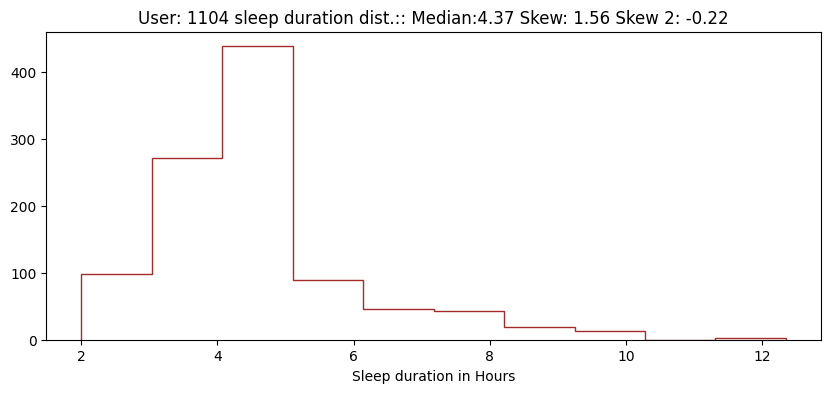

In [25]:
from scipy.stats import skew
sleep_durations = sleep_sample[sleep_sample['user_id'] == chosen_user]['sleep_duration_round']
_skew= np.round(skew(sleep_durations),2)
_med= np.round(np.median(sleep_durations),2)
_avg = np.round(np.mean(sleep_durations),2)
_skew2 = np.round(_med-_avg,2)
print(_skew, _med)
plt.figure(figsize=(10,4))
plt.hist(sleep_durations, histtype='step',color='brown')
title_text = "User: "+str(chosen_user)+" sleep duration dist.:: Median:"+str(_med)+" Skew: "+str(_skew)+" Skew 2: "+str(_skew2)
plt.title(title_text)
plt.xlabel("Sleep duration in Hours")
plt.savefig("/file/out/antar/_user_1182_hist.png",dpi=400)
plt.show()


In [26]:
from itertools import cycle
# time_vals = np.arange(0.0, 23.75, 0.25)
# time_vals =np.insert(time_vals,(24*4-1),23.75)
# time_vals
pool = cycle(time_vals)
l= [] 
c=0
for n in pool:
    if c >=48*4 :
        break
    else:
        l.append(n)
        c+=1

l[90:100]

[22.5, 22.75, 23.0, 23.25, 23.5, 23.75, 0.0, 0.25, 0.5, 0.75]

In [27]:
'''
setting up two examples:

03-19-2016 : 0.00 to 8.25
03-19-2016 : 22.75 to 8.0
'''

aa = [] # initializing empty list to hold sleep start shift and .25 hour time intervals of sleep
for i in range(len(cc)): # for each sleep entry
    first_index = l.index(cc.iloc[i]["start_time_num_round_25"])

    if cc.iloc[i]["start_time_num_round_25"] > cc.iloc[i]["end_time_num_round_25"]: #start time is at night and wakes up next morning
        last_index =  l.index(cc.iloc[i]["end_time_num_round_25"])+ (24*4)
        counter = first_index

        while counter < last_index:
            if (l[counter] >= 0) & (l[counter] <  cc.iloc[i]["start_time_num_round_25"]):
                aa.append([cc.iloc[i]["sleep_start"]+np.timedelta64(1, 'D'),l[counter]])

            else:
                aa.append([cc.iloc[i]["sleep_start"],l[counter]])

            counter+=1

    else:
        last_index =  l.index(cc.iloc[i]["end_time_num_round_25"])
        counter = first_index

        while counter < last_index:
            aa.append([cc.iloc[i]["sleep_start"], l[counter]])

            counter+=1    
sleep_times = pd.DataFrame(aa)
sleep_times.columns = ["sleep_start","start_time_num_round_25"]
sleep_times["user_id"] = chosen_user
sleep_times.head()

,sleep_start,start_time_num_round_25,user_id
0,2017-08-21,1.25,1104
1,2017-08-21,1.50,1104
2,2017-08-21,1.75,1104
3,2017-08-21,2.00,1104
4,2017-08-21,2.25,1104


In [28]:
sleep_times.tail()

,sleep_start,start_time_num_round_25,user_id
2649,2018-01-05,4.75,1104
2650,2018-01-05,5.00,1104
2651,2018-01-05,5.25,1104
2652,2018-01-05,5.50,1104
2653,2018-01-05,5.75,1104


In [29]:
date_sleep_combo = date_sleep_combo.merge(sleep_times,how = 'left',
                                          left_on = ["sleep_start", "start_time_num_round_25"],
                                         right_on = ["sleep_start", "start_time_num_round_25"])

date_sleep_combo["asleep_0_awake_300"] = np.where(date_sleep_combo["user_id"].isna(), 300,0)
print("number of rows: ",len(date_sleep_combo))
date_sleep_combo.head()

number of rows:  13152


,sleep_start,start_time_num_round_25,user_id,asleep_0_awake_300
0,2017-08-21,0.00,NaN,300
1,2017-08-21,0.25,NaN,300
2,2017-08-21,0.50,NaN,300
3,2017-08-21,0.75,NaN,300
4,2017-08-21,1.00,NaN,300


In [30]:
date_sleep_combo.tail()

,sleep_start,start_time_num_round_25,user_id,asleep_0_awake_300
13147,2018-01-04,22.75,NaN,300
13148,2018-01-04,23.00,NaN,300
13149,2018-01-04,23.25,NaN,300
13150,2018-01-04,23.50,NaN,300
13151,2018-01-04,23.75,NaN,300


In [31]:
cc2 = cc[cc['sleep_start_shift'].isin(list(date_sleep_combo['sleep_start'].unique()))]
cc2

,user_id,sleep_start,sleep_start_shift,day_of_week,weekend,start_time_num_round_25,end_time_num_round_25,sleep_duration,sleep_duration_round,nap,shift_sleep,count,lag_sleep_start_shift,continuous_data_sleep,lag_user_id
1,1104,2017-08-22,2017-08-21,Monday,0,1.25,5.75,15720,4.37,0,0,2,2017-08-20,1,1104.0
2,1104,2017-08-23,2017-08-22,Tuesday,0,2.00,5.75,13440,3.73,0,0,3,2017-08-21,1,1104.0
3,1104,2017-08-24,2017-08-23,Wednesday,0,0.25,5.50,19080,5.30,0,0,4,2017-08-22,1,1104.0
4,1104,2017-08-24,2017-08-24,Thursday,0,23.50,3.50,14760,4.10,0,0,5,2017-08-23,1,1104.0
5,1104,2017-08-25,2017-08-25,Friday,1,22.50,7.50,29100,8.08,0,0,6,2017-08-24,1,1104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1104,2018-01-01,2017-12-31,Sunday,0,4.75,8.50,13620,3.78,0,0,134,2017-12-30,1,1104.0
134,1104,2018-01-02,2018-01-01,Monday,0,1.50,5.75,15960,4.43,0,0,135,2017-12-31,1,1104.0
135,1104,2018-01-03,2018-01-02,Tuesday,0,3.50,8.25,16920,4.70,0,0,136,2018-01-01,1,1104.0
136,1104,2018-01-04,2018-01-03,Wednesday,0,2.00,7.00,17760,4.93,0,0,137,2018-01-02,1,1104.0


Min duration of catchup sleep:  5.32


/tmp/ipykernel_3978959/3711352586.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SleepingDatesActual = cc2[(cc['user_id'] == chosen_user) &(cc2['nap']==0)]['sleep_start']
/tmp/ipykernel_3978959/3711352586.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SleepingDates_naps = cc2[(cc['user_id'] == chosen_user) &(cc2['nap']==1)]['sleep_start_shift']
/tmp/ipykernel_3978959/3711352586.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weekend = np.array(cc2[(cc2['user_id'] == chosen_user) &(cc['nap']==0)]['weekend'])


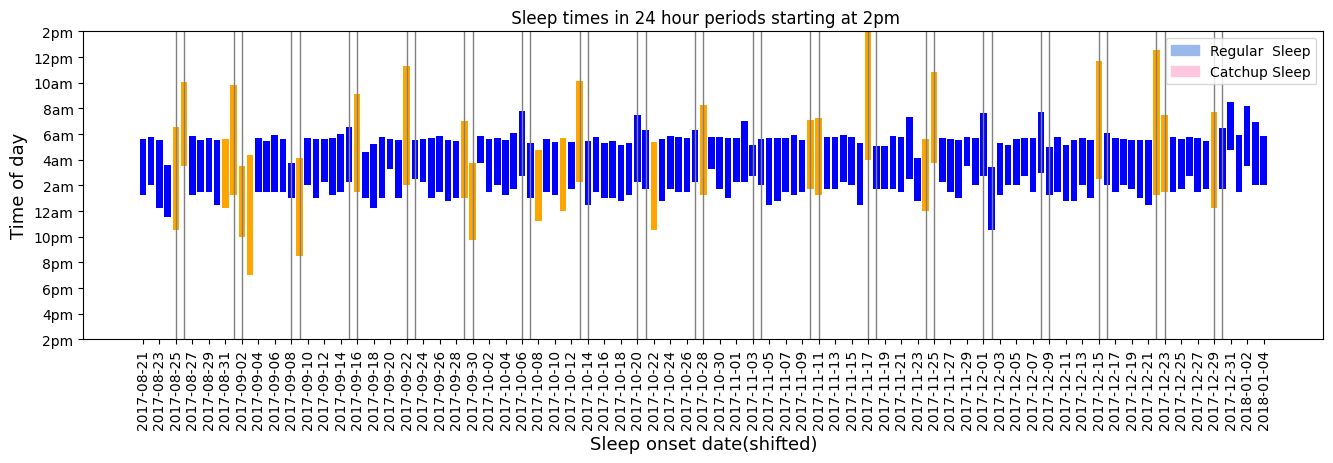

In [32]:
'''
if there is a date that has been dropped from the beginning then that row should be eliminated from the cc
table because that day's DLMO prediction is not being performed so there is no use showing it in the plot.
'''
# if date_to_be_dropped !=None:
#     cc = cc[cc['sleep_start']> date_to_be_dropped]

sleeping = np.array(cc2[(cc2['user_id'] == chosen_user) &(cc2['nap']==0)]['start_time_num_round_25'])
sleeping_naps = np.array(cc2[(cc2['user_id'] == chosen_user) &(cc2['nap']==1)]['start_time_num_round_25'])
sleeping_48hour = []
for sleeping_time in sleeping:
    if sleeping_time < 12.00:
        sleeping_48hour.append(sleeping_time+24.00)
    else:
        sleeping_48hour.append(sleeping_time) 
        
        sleeping_48hour_naps = []
for sleeping_time in sleeping_naps:
    if sleeping_time < 12.00:
        sleeping_48hour_naps.append(sleeping_time+24.00)
    else:
        sleeping_48hour_naps.append(sleeping_time) 
                
SleepingDates = cc2[(cc2['user_id'] == chosen_user) &(cc2['nap']==0)]['sleep_start_shift']
SleepingDatesActual = cc2[(cc['user_id'] == chosen_user) &(cc2['nap']==0)]['sleep_start']
SleepingDates_naps = cc2[(cc['user_id'] == chosen_user) &(cc2['nap']==1)]['sleep_start_shift']
sleep_duration = cc2[(cc2['user_id'] == chosen_user) &(cc2['nap']==0)]['sleep_duration_round']

SleepingDates_48hr = pd.DataFrame(zip(SleepingDates,SleepingDatesActual, sleeping_48hour,sleep_duration),
                                  columns=['sleep_start_shift','sleep_start',
                                           'start_time_num_round_25','sleep_duration_round']) #converting to df

# 'identifying the catchup sleeps - above the chosen percentile'
chosen_ntile = 0.5
catchup_sleep  = SleepingDates_48hr['sleep_duration_round'].quantile(chosen_ntile)+1
print("Min duration of catchup sleep: ",catchup_sleep)

weekend = np.array(cc2[(cc2['user_id'] == chosen_user) &(cc['nap']==0)]['weekend'])

# if date_to_be_dropped != None:
#     weekend = np.array(cc[(cc['user_id'] == chosen_user) &(cc['nap']==0)& (cc['sleep_start']>date_to_be_dropped)]['weekend'])
# else:
#     weekend = np.array(cc[(cc['user_id'] == chosen_user) &(cc['nap']==0)]['weekend'])

color_for_bars = []
for i in range(len(SleepingDates_48hr)):
    if SleepingDates_48hr['sleep_duration_round'].iloc[i] >= catchup_sleep:
        color_for_bars.append("orange")
    else:
        color_for_bars.append('blue')
    
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round_25'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round_25'],color=color_for_bars)
#         color='#9BB8ED')

set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
for i in range(len(weekend)):
    if weekend[i]== 1:
        plt.axvline(x=SleepingDates_48hr['sleep_start_shift'].iloc[i],linewidth=1,color="grey",label='Weekend')  

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")
# plt.set_xticklabels(date_list2)
plt.tick_params('x',rotation=90)
plt.title(" Sleep times in 24 hour periods starting at 2pm")
plt.xlabel("Sleep onset date(shifted)",fontsize=13)
plt.ylabel("Time of day",fontsize=13)

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color = '#9BB8ED',label = 'Regular  Sleep')
pink_patch = mpatches.Patch(color = '#FEC6DF',label = 'Catchup Sleep')
plt.legend(handles = [blue_patch, pink_patch])

plt.show()

In [33]:
x1_x2_dlmo_df = pd.read_csv("/data/work/shared/s210142/datasets/x1_x2_dlmo_actual.csv")
x1_x2_dlmo_df['sleeponset'] = np.round(x1_x2_dlmo_df['dlmo']+2.0,2)
x1_x2_dlmo_df.drop(columns={'Unnamed: 0'},inplace=True)
x1_x2_dlmo_df['diff'] = abs(x1_x2_dlmo_df['sleeponset']-SleepingDates_48hr.loc[0, 'start_time_num_round_25'])
x1 = x1_x2_dlmo_df[x1_x2_dlmo_df['diff']==np.min(x1_x2_dlmo_df['diff'])]['x1'].values[0]
x2 = x1_x2_dlmo_df[x1_x2_dlmo_df['diff']==np.min(x1_x2_dlmo_df['diff'])]['x2'].values[0]
print("x1: ",x1, " x2: ",x2)

x1:  0.25  x2:  -1.02


# Kronauer seventh order model

In [34]:
from scipy.signal import find_peaks
def initial_conditions_loop(ts: np.ndarray, #Array of time points, also determines step size of RK4 solver
                                light_est: np.ndarray, #Array of light estimates, should be the same length as ts
                                num_loops: int = 30) -> np.ndarray: 
        """ 
            Estimate the starting values by looping the given light_estimate, commonly used for to estimate the initial conditions
            assumes the individual lives the same schedule repeatedly
        """
        y = np.array([-0.3,-1.13,0.0])
#         y = np.array([-0.52, -1.02, 0.0])
        #ic = self.default_initial_conditions
        for _ in range(num_loops):
            sol = integrate_model(ts, light_est, y)
            y = sol[..., -1]
        return y,sol

def integrate_model(ts: np.array,  # Array of time points, also determines step size of RK4 solver
                    light_est: np.array,  # Array of light estimates, should be the same length as ts
                    state: np.array,  # Initial state of the model
                    ):
    nloop = len(ts)
    print("n: ",nloop)
    sol = np.zeros([state.shape[0], nloop])
    sol[..., 0] = state
    print(sol[...,0])
    for idx in range(1, nloop):
        state = step_rk4(
        state=state,
        light_val=light_est[idx],
        dt=ts[idx]-ts[idx-1])
        sol[..., idx] = state
#     print("sol shape: ",sol.shape)
    return sol

def step_rk4(state: np.ndarray, #dy/dt = f(y, t)
              light_val: float, #light value at time t in lux
              dt=float #step size in hours
            ):
    k1 = derv(state, light=light_val)
    k2 = derv(state + k1 * dt / 2.0, light=light_val)
    k3 = derv(state + k2 * dt / 2.0, light=light_val)
    k4 = derv(state + k3 * dt, light=light_val)
    state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    #   print("state: ",state)
    return state

def derv(y: np.array, #state vector (x, xc, n)
        light: float, #light value in lux
        ):

        taux = 24.2;
        G = 19.875;
        b = 0.013;
        k = .55;
        
        mu = .1300;
        q = 1.0/3;
        
        I0 = 9500;
        p = .6;
        a0 = 0.16;
        
        # Relational parameters to circadian markers
        phi_ref = 0.80; # relative to x min to get CBTmin, units of hours
        dlmo_convert = -7.0 #factor to convert from CBTmin to DLMO
        
        x =y[0]
        xc = y[1]
        n = y[2]
        #print("x: ",x," xc: ",xc, " n: ",n)
        
        alpha = a0*(light/I0)**p;
        Bh = G*alpha*(1-n);
        B = Bh*(1-0.4*x)*(1-0.4*xc);
               
        dydt = np.zeros_like(y)
        dydt[0] = np.pi/12* (xc + mu*(1/3*x+4/3*x**3-256/105*x**7) + B);
        dydt[1] = np.pi/12* (q*B*xc - x*((24/(0.99729*taux))**2 + k*B));
        dydt[2] = 60*(alpha*(1-n) - b*n);
        return dydt
    
def cbt(sol):
        phi_ref = 0.8
        cbt_mins_test = find_peaks(-1*sol[0,:])[0]
        cbt_mins = find_peaks(-1*sol[0,:], distance =60 )[0] # min of x is the CBTmin
        # height condition so that peaks in the opposite direction are not considered, distance to ensure peaks are not chosen too close
        cbts = sol[0,:]
        print("cbts: ",len(cbts))
        
        plt.figure(figsize=(16,4))
        plt.xlabel("Day labels")
        plt.ylabel("cbts")
        plt.plot(cbts)
        plt.plot(cbt_mins_test, cbts[cbt_mins_test], "x",color = "red")
        plt.title("CBT signal and identified peaks without distance constraints")
        plt.show()
        
        
        plt.figure(figsize=(16,4))
        plt.xlabel(" $t$ (Quarter of an hour)",fontsize=12)
        plt.ylabel("cbts",fontsize=12)
        plt.plot(cbts)
        plt.plot(cbt_mins, cbts[cbt_mins], "x",color = "red")
        plt.title("CBT signal and identified peaks")
        plt.show()
        print("length cbt mins:",cbt_mins.shape)
#         print("cbt: ",ts[cbt_mins] + phi_ref)
        return ts[cbt_mins] + phi_ref
    
def dlmos(sol):
        dlmo_convert = -7
        return cbt(sol) + dlmo_convert # dlmo is defines by a relationship to cbt for this model


## adding sleep wake cycle

In [35]:
light_values = np.array(date_sleep_combo["asleep_0_awake_300"])
print(type(light_values),len(light_values))
time_array = np.arange(0,len(light_values))
light_values

<class 'numpy.ndarray'> 13152


array([300, 300, 300, ..., 300, 300, 300])

In [36]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(16,4))
# plt.title("Markers at every 24th hour")
# plt.plot(light_values)
hr24marker = int(len(light_values)/(24*4))
print("Whole days: ",hr24marker)
# for i in range(hr24marker):
#     plt.axvline(i*24*4,color='red',linestyle='--')
# plt.show()

Whole days:  137


len of ts:  13152
n:  13152
[-0.3  -1.13  0.  ]
initial conditions: [-0.06149814 -1.25774169  0.60755962]
cbts:  13152


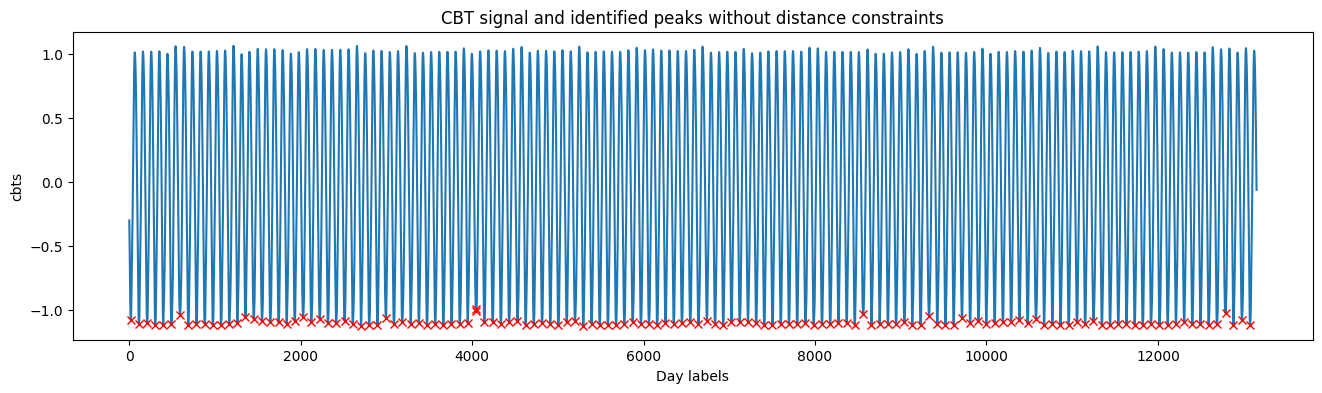

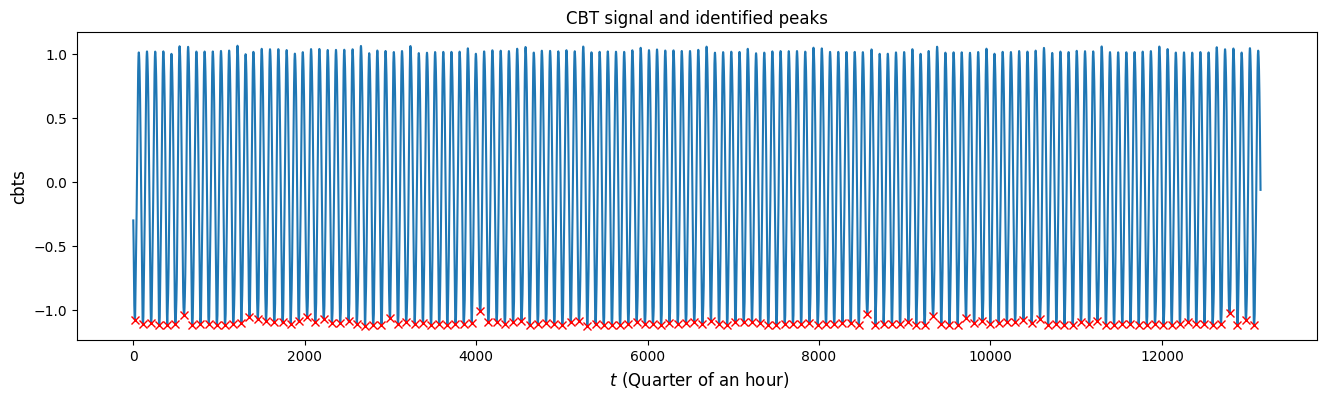

length cbt mins: (137,)
length of time array:  13152 length of dlmo:  137
137


In [37]:
ts = np.arange(0, 24*hr24marker, 0.25)
print("len of ts: ",len(ts))

initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=light_values, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
print(len(dlmo_kj))
# for data in np.array(dlmo_kj):
#     print("{:9.2f}".format(data))

In [38]:
type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
print(dlmo_kj)

[-1.700000 21.800000 46.050000 69.550000 93.050000 116.550000 141.800000
 165.800000 189.800000 213.800000 237.550000 261.300000 285.550000
 309.300000 332.800000 356.800000 380.800000 405.050000 429.300000
 453.300000 476.550000 500.800000 524.800000 549.300000 573.050000
 597.300000 621.550000 645.550000 669.800000 693.550000 717.550000
 742.300000 765.550000 789.800000 814.550000 838.550000 862.050000
 886.050000 909.800000 933.550000 957.550000 981.050000 1005.800000
 1029.300000 1053.550000 1077.550000 1101.550000 1126.050000 1149.800000
 1173.550000 1197.550000 1221.550000 1245.300000 1269.550000 1293.800000
 1318.050000 1342.050000 1365.800000 1389.800000 1413.550000 1437.550000
 1461.800000 1486.050000 1509.300000 1533.300000 1557.550000 1581.550000
 1605.550000 1629.800000 1653.800000 1678.550000 1702.300000 1725.800000
 1750.050000 1774.050000 1798.300000 1822.300000 1845.800000 1869.550000
 1893.800000 1917.550000 1941.800000 1965.800000 1989.800000 2014.050000
 2038.050000 

In [39]:
dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))

[22.300000 21.800000 22.050000 21.550000 21.050000 20.550000 21.800000
 21.800000 21.800000 21.800000 21.550000 21.300000 21.550000 21.300000
 20.800000 20.800000 20.800000 21.050000 21.300000 21.300000 20.550000
 20.800000 20.800000 21.300000 21.050000 21.300000 21.550000 21.550000
 21.800000 21.550000 21.550000 22.300000 21.550000 21.800000 22.550000
 22.550000 22.050000 22.050000 21.800000 21.550000 21.550000 21.050000
 21.800000 21.300000 21.550000 21.550000 21.550000 22.050000 21.800000
 21.550000 21.550000 21.550000 21.300000 21.550000 21.800000 22.050000
 22.050000 21.800000 21.800000 21.550000 21.550000 21.800000 22.050000
 21.300000 21.300000 21.550000 21.550000 21.550000 21.800000 21.800000
 22.550000 22.300000 21.800000 22.050000 22.050000 22.300000 22.300000
 21.800000 21.550000 21.800000 21.550000 21.800000 21.800000 21.800000
 22.050000 22.050000 22.050000 22.050000 21.550000 22.550000 22.550000
 22.550000 22.300000 22.050000 22.300000 21.800000 21.550000 22.300000
 22.55

In [40]:
len(dlmo_kj2)

137

In [41]:
SleepingDates_48hr.tail(n=3)

,sleep_start_shift,sleep_start,start_time_num_round_25,sleep_duration_round
134,2018-01-02,2018-01-03,27.5,4.70
135,2018-01-03,2018-01-04,26.0,4.93
136,2018-01-04,2018-01-05,26.0,3.88


In [42]:
def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker
    
sleep_48hr = list(SleepingDates_48hr['start_time_num_round_25'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+24.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_sleepwake = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(None)
        
for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr['sleep_start_shift'].dt.date), 
                                                          np.array(SleepingDates_48hr['start_time_num_round_25']),
                                                          EstimatedSleepOnset,
                                               MinutesBetweenPredictedAndActualSleep_sleepwake):
    print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    


sleep date: 2017-08-21 Actual sleep time: 25.25 Estimated sleep time:  24.3 Minutes in between:  -57.0
sleep date: 2017-08-22 Actual sleep time: 26.0 Estimated sleep time:  23.8 Minutes in between:  -132.0
sleep date: 2017-08-23 Actual sleep time: 24.25 Estimated sleep time:  24.05 Minutes in between:  -12.0
sleep date: 2017-08-24 Actual sleep time: 23.5 Estimated sleep time:  23.55 Minutes in between:  3.0
sleep date: 2017-08-25 Actual sleep time: 22.5 Estimated sleep time:  23.05 Minutes in between:  33.0
sleep date: 2017-08-26 Actual sleep time: 27.5 Estimated sleep time:  22.55 Minutes in between:  -297.0
sleep date: 2017-08-27 Actual sleep time: 25.25 Estimated sleep time:  23.8 Minutes in between:  -87.0
sleep date: 2017-08-28 Actual sleep time: 25.5 Estimated sleep time:  23.8 Minutes in between:  -102.0
sleep date: 2017-08-29 Actual sleep time: 25.5 Estimated sleep time:  23.8 Minutes in between:  -102.0
sleep date: 2017-08-30 Actual sleep time: 24.5 Estimated sleep time:  23.8

In [43]:
print(len(SleepingDates_48hr['sleep_start_shift']),len(SleepingDates_48hr['start_time_num_round_25']),
     len(EstimatedSleepOnset),len(dlmo_kj2))

137 137 137 137


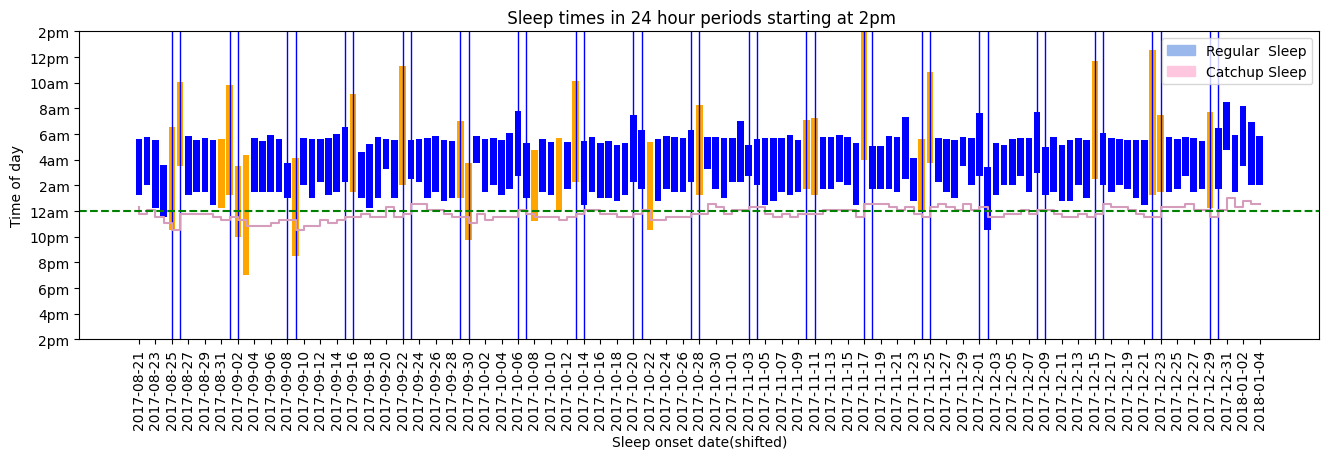

In [44]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round_25'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round_25'],color=color_for_bars)
#         color='#9BB8ED')
axs.scatter(SleepingDates_naps,sleeping_48hour_naps, color='blue', marker='x',label='Nap onset(Btwn 11-15hrs,dur <3hr)')


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
for i in range(len(weekend)):
    if weekend[i]== 1:
        plt.axvline(x=SleepingDates_48hr['sleep_start_shift'].iloc[i],linewidth=1,color="blue")  

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")
# plt.set_xticklabels(date_list2)
plt.tick_params('x',rotation=90)
plt.title(" Sleep times in 24 hour periods starting at 2pm")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color = '#9BB8ED',label = 'Regular  Sleep')
pink_patch = mpatches.Patch(color = '#FEC6DF',label = 'Catchup Sleep')
plt.legend(handles = [blue_patch, pink_patch],loc='upper right')


# dlmo_trunc = len(SleepingDates_48hr['start_time_num_round_25'])
EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='#D69CBC', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.scatter(SleepingDates_naps,sleeping_48hour_naps, color='blue', marker='x',label='Nap onset(Btwn 11-15hrs,dur <3hr)')
# axs.grid(color='0.95')
axs.axhline(y=24, linestyle='dashed',color='green',label='midnight')


plt.show()

## adding in the phone usage information

In [45]:
#        |--------------|
#     |-----------| ok
#                |-----------| ok
# |------------------------------|
#            |------| ok


selected_phone_streaks = []
_user_Phone = PhoneContInnings_df[(PhoneContInnings_df['user_id']== chosen_user) & 
                                                (PhoneContInnings_df['count']>7)]
_user_Phone = _user_Phone[~(_user_Phone['phone_streak_start_date'] > chosen_user_streak_end)]
_user_Phone = _user_Phone[~(_user_Phone['phone_streak_end_date'] < chosen_user_streak_start)]
_user_Phone = _user_Phone[['user_id','day_label','phone_streak_start_date','phone_streak_end_date',
                          'count']]

for i in range(len(_user_Phone)):
    if _user_Phone['phone_streak_start_date'].iloc[i]>= chosen_user_streak_start:
        if _user_Phone['phone_streak_end_date'].iloc[i] <= chosen_user_streak_end:
            selected_phone_streaks.append([_user_Phone['phone_streak_start_date'].iloc[i],
                                           _user_Phone['phone_streak_end_date'].iloc[i],
                                           _user_Phone['count'].iloc[i]])
        elif _user_Phone['phone_streak_end_date'].iloc[i] > chosen_user_streak_end:
 
            selected_phone_streaks.append([_user_Phone['phone_streak_start_date'].iloc[i],chosen_user_streak_end,
                                           (chosen_user_streak_end-_user_Phone['phone_streak_start_date'].iloc[i]).days])
    
    elif _user_Phone['phone_streak_start_date'].iloc[i] < chosen_user_streak_start:
        if _user_Phone['phone_streak_end_date'].iloc[i] <= chosen_user_streak_end:
            selected_phone_streaks.append([chosen_user_streak_start,_user_Phone['phone_streak_end_date'].iloc[i],
                                           (_user_Phone['phone_streak_end_date'].iloc[i]-chosen_user_streak_start).days])
        
        elif _user_Phone['phone_streak_end_date'].iloc[i] > chosen_user_streak_end:
            selected_phone_streaks.append([chosen_user_streak_start, chosen_user_streak_end,
                                           chosen_user_streak_length])
            
selected_phone_streaks_df = pd.DataFrame(selected_phone_streaks,columns=['phone_user_streak_start',
                                                                          'phone_user_streak_end','count'])         


selected_phone_streaks_df['user_id'] = chosen_user

selected_phone_streaks_df.sort_values(by='count',ascending=False,inplace=True)

phone_chosen_user_streak_start = selected_phone_streaks_df['phone_user_streak_start'].iloc[0]
phone_chosen_user_streak_end = selected_phone_streaks_df['phone_user_streak_end'].iloc[0]

print("phone streak: ","\nstart: ",phone_chosen_user_streak_start, "\nend  : ",phone_chosen_user_streak_end)

selected_phone_streaks_df.head()

phone streak:  
start:  2017-08-21 00:00:00 
end  :  2018-01-05 00:00:00


,phone_user_streak_start,phone_user_streak_end,count,user_id
0,2017-08-21,2018-01-05,137,1104


In [46]:
import math
pp = phone_sample[(phone_sample["user_id"]==chosen_user) &
                  (phone_sample["day_label_dt"]>=  phone_chosen_user_streak_start) &
                  (phone_sample["day_label_dt"] <=  phone_chosen_user_streak_end)]
pp = pp.reset_index()

pp.drop(columns={"index"},inplace=True)
'''rounding the start and end times of sleep to the nearest quarter for ease of calculation. will preserve
sleep duration calculation'''
pp['start_time_num_round_25'] = ((pp['start_time_num_round']%1)*100/60)+pp['start_time_num_round'].astype(int)
pp['start_time_num_round_25'] = round(pp['start_time_num_round_25']*4)/4
pp['start_time_num_round_25'] = np.where(((pp['start_time_num_round_25'] >= 23.45) &
                                          (pp['start_time_num_round_25'] < 24.0)), 
                                         23.75,pp['start_time_num_round_25'])


pp = pp[['day_label_dt','start_time_num_round_25','duration']].groupby(['day_label_dt','start_time_num_round_25']).sum().reset_index()
pp.rename(columns={'day_label_dt':'day_label'},inplace=True)
pp.head()

,day_label,start_time_num_round_25,duration
0,2017-08-21,0.00,4
1,2017-08-21,6.00,243
2,2017-08-21,6.75,545
3,2017-08-21,7.00,886
4,2017-08-21,7.25,567


In [47]:
first_date_phone_available= np.min(pp['day_label'])
last_date_phone_available= np.max(pp['day_label'])
print("min and max cut offs of phone data: ",first_date_phone_available," and ", last_date_phone_available)

min and max cut offs of phone data:  2017-08-21 00:00:00  and  2018-01-05 00:00:00


In [48]:
starting_date_pp = pp["day_label"].min()

starting_time_pp = pp.sort_values(by=["day_label","start_time_num_round_25"])["start_time_num_round_25"].values[0]

time_vals = np.arange(0.0, 23.75, 0.25)
time_vals = np.append(time_vals,23.75)

unique_dates = pp['day_label'].unique()
print("Initial unique dates length: ",len(unique_dates))
unique_dates = [x for x in unique_dates if x not in date_to_be_dropped]
print("Initial unique dates length: ",len(unique_dates))

import itertools
date_phone_combo =pd.DataFrame(list(itertools.product(np.unique(unique_dates),time_vals)))
date_phone_combo.columns = ["day_label", "start_time_num_round_25"]
date_phone_combo = date_phone_combo[date_phone_combo['day_label']<=last_date_phone_available]
print("number of days: ", len(date_phone_combo['day_label'].unique()),"\ntime vals: ", time_vals)

Initial unique dates length:  138
Initial unique dates length:  137
number of days:  137 
time vals:  [0.000000 0.250000 0.500000 0.750000 1.000000 1.250000 1.500000 1.750000
 2.000000 2.250000 2.500000 2.750000 3.000000 3.250000 3.500000 3.750000
 4.000000 4.250000 4.500000 4.750000 5.000000 5.250000 5.500000 5.750000
 6.000000 6.250000 6.500000 6.750000 7.000000 7.250000 7.500000 7.750000
 8.000000 8.250000 8.500000 8.750000 9.000000 9.250000 9.500000 9.750000
 10.000000 10.250000 10.500000 10.750000 11.000000 11.250000 11.500000
 11.750000 12.000000 12.250000 12.500000 12.750000 13.000000 13.250000
 13.500000 13.750000 14.000000 14.250000 14.500000 14.750000 15.000000
 15.250000 15.500000 15.750000 16.000000 16.250000 16.500000 16.750000
 17.000000 17.250000 17.500000 17.750000 18.000000 18.250000 18.500000
 18.750000 19.000000 19.250000 19.500000 19.750000 20.000000 20.250000
 20.500000 20.750000 21.000000 21.250000 21.500000 21.750000 22.000000
 22.250000 22.500000 22.750000 23.00

In [49]:
date_phone_combo = date_phone_combo.merge(pp,how = 'left',
                                          left_on = ["day_label", "start_time_num_round_25"],
                                         right_on = ["day_label", "start_time_num_round_25"])
date_phone_combo['duration'] = date_phone_combo['duration'].fillna(0)


date_phone_combo= date_phone_combo.merge(date_sleep_combo,how='left', 
                                         left_on = ['day_label','start_time_num_round_25'],
                                        right_on = ['sleep_start','start_time_num_round_25'])
date_phone_combo['duration']=np.where(date_phone_combo['asleep_0_awake_300'] ==0,0,
                                     date_phone_combo['duration'])

# date_phone_combo.drop(columns={'sleep_start','user_id','asleep_0_awake_300'},inplace=True)

date_phone_combo['day_label'] = date_phone_combo['day_label'].dt.date
print("number of rows: ",len(date_phone_combo))
date_phone_combo.head()

number of rows:  13152


,day_label,start_time_num_round_25,duration,sleep_start,user_id,asleep_0_awake_300
0,2017-08-21,0.00,4.0,2017-08-21,NaN,300
1,2017-08-21,0.25,0.0,2017-08-21,NaN,300
2,2017-08-21,0.50,0.0,2017-08-21,NaN,300
3,2017-08-21,0.75,0.0,2017-08-21,NaN,300
4,2017-08-21,1.00,0.0,2017-08-21,NaN,300


In [50]:
date_phone_combo[(date_phone_combo['asleep_0_awake_300']==300) &
                 (date_phone_combo['sleep_start']== '2017-12-01')]

,day_label,start_time_num_round_25,duration,sleep_start,user_id,asleep_0_awake_300
9792,2017-12-01,0.00,588.0,2017-12-01,NaN,300
9793,2017-12-01,0.25,258.0,2017-12-01,NaN,300
9794,2017-12-01,0.50,0.0,2017-12-01,NaN,300
9795,2017-12-01,0.75,0.0,2017-12-01,NaN,300
9796,2017-12-01,1.00,0.0,2017-12-01,NaN,300
...,...,...,...,...,...,...
9883,2017-12-01,22.75,0.0,2017-12-01,NaN,300
9884,2017-12-01,23.00,0.0,2017-12-01,NaN,300
9885,2017-12-01,23.25,827.0,2017-12-01,NaN,300
9886,2017-12-01,23.50,0.0,2017-12-01,NaN,300


Heatmap of phone usage in seconds (Darker shades indicates usage)


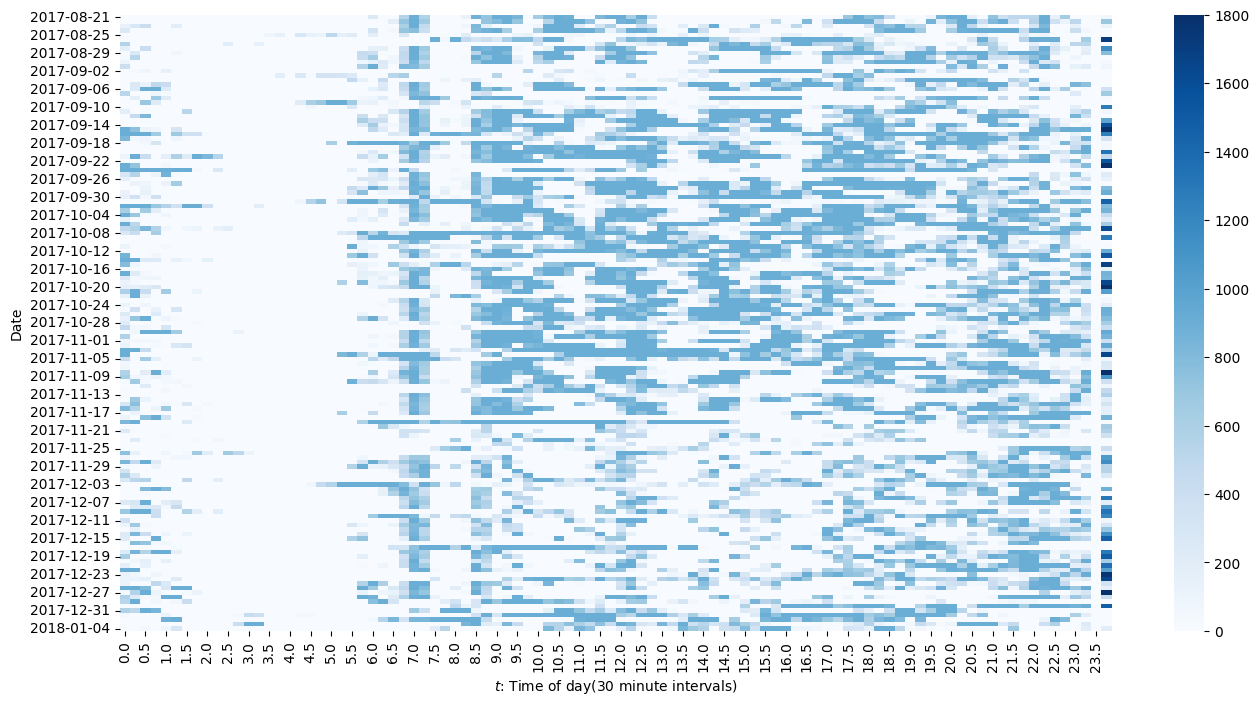

In [83]:
date_phone_combo_heatmap = pd.pivot_table(date_phone_combo,values='duration',
                                                       index='day_label',
                                                       columns='start_time_num_round_25')
import seaborn as sns
fig,axs = plt.subplots(figsize=(16,8))
sns.heatmap(date_phone_combo_heatmap,cmap='Blues',ax=axs)
# axs.vlines([22.0], *axs.get_xlim(),color='pink')
plt.xlabel("$t$: Time of day(30 minute intervals)")
plt.ylabel("Date")
# plt.title("Heatmap of phone usage in seconds (Darker shades indicates usage)")
print("Heatmap of phone usage in seconds (Darker shades indicates usage)")
plt.savefig("/file/out/antar/_user_1104_heatmap_phone_nonscaled.png",dpi=400)
plt.show()

In [52]:
date_phone_combo[date_phone_combo['duration']>0]

,day_label,start_time_num_round_25,duration,sleep_start,user_id,asleep_0_awake_300
0,2017-08-21,0.00,4.0,2017-08-21,NaN,300
24,2017-08-21,6.00,243.0,2017-08-21,NaN,300
27,2017-08-21,6.75,545.0,2017-08-21,NaN,300
28,2017-08-21,7.00,886.0,2017-08-21,NaN,300
29,2017-08-21,7.25,567.0,2017-08-21,NaN,300
...,...,...,...,...,...,...
13135,2018-01-04,19.75,5.0,2018-01-04,NaN,300
13139,2018-01-04,20.75,5.0,2018-01-04,NaN,300
13142,2018-01-04,21.50,685.0,2018-01-04,NaN,300
13149,2018-01-04,23.25,184.0,2018-01-04,NaN,300


In [53]:
phone_values = np.array(date_phone_combo["duration"])
print(type(phone_values),len(phone_values))
time_array = np.arange(0,len(phone_values))
phone_values

<class 'numpy.ndarray'> 13152


array([4.000000, 0.000000, 0.000000, ..., 184.000000, 0.000000,
       195.000000])

In [54]:
import matplotlib.pyplot as plt

hr24marker = int(len(phone_values)/(24*4))
print("Whole days: ",hr24marker)


Whole days:  137


len of ts:  13152
n:  13152
[-0.300000 -1.130000 0.000000]
initial conditions: [-0.343197 -1.090225 0.334242]
cbts:  13152


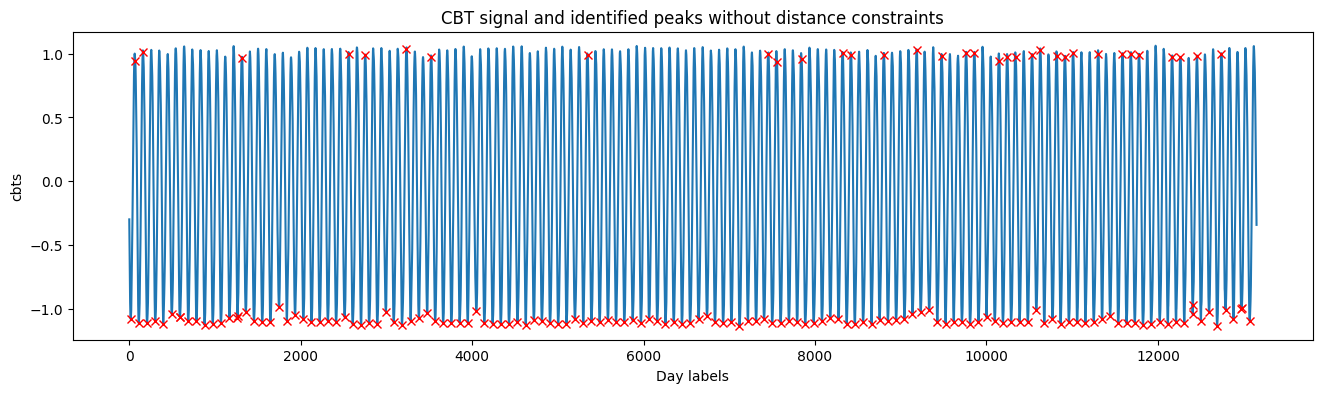

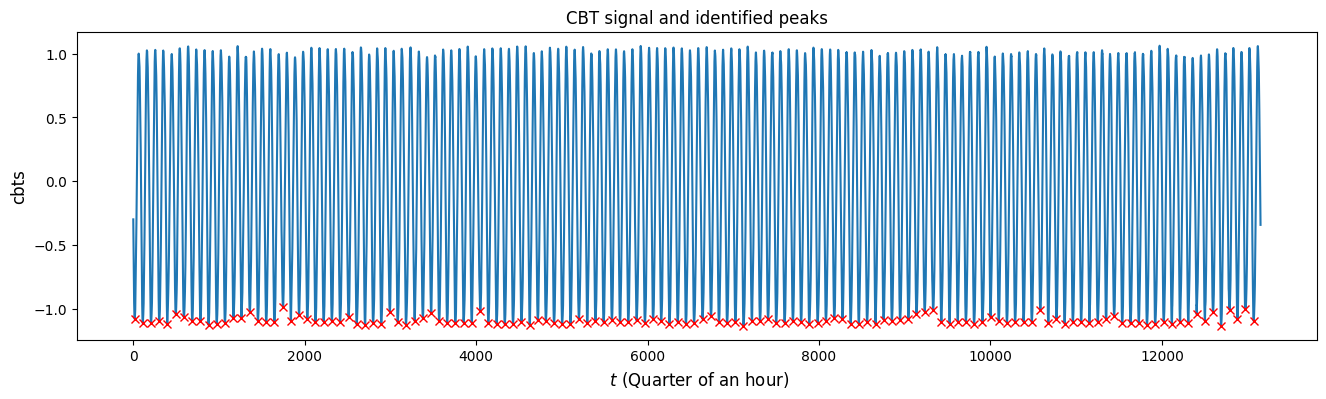

length cbt mins: (137,)
length of time array:  13152 length of dlmo:  137
137


In [55]:
ts = np.arange(0, 24*hr24marker, 0.25)
print("len of ts: ",len(ts))

initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=phone_values, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
print(len(dlmo_kj))
# for data in np.array(dlmo_kj):
#     print("{:9.2f}".format(data))

In [56]:
type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
print(dlmo_kj)

[-2.200000 21.300000 45.550000 69.550000 93.050000 117.550000 141.550000
 165.800000 189.550000 213.300000 237.050000 261.050000 286.050000
 309.300000 333.800000 357.300000 381.550000 405.300000 430.550000
 453.300000 477.300000 501.300000 525.050000 549.050000 572.800000
 597.050000 621.800000 645.300000 669.800000 693.300000 717.050000
 742.050000 765.050000 789.050000 814.550000 838.300000 862.800000
 886.050000 909.300000 933.050000 957.300000 980.800000 1006.050000
 1029.300000 1053.300000 1077.300000 1101.300000 1125.800000 1150.050000
 1173.550000 1197.050000 1221.050000 1244.800000 1268.800000 1293.300000
 1317.800000 1341.800000 1365.550000 1389.800000 1413.550000 1437.550000
 1461.800000 1486.050000 1509.800000 1533.550000 1557.300000 1581.550000
 1605.550000 1629.300000 1654.050000 1678.800000 1702.050000 1725.800000
 1749.800000 1773.550000 1798.050000 1821.800000 1845.050000 1869.050000
 1893.300000 1917.550000 1941.550000 1965.300000 1989.800000 2014.050000
 2038.300000 

In [57]:
dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))

[21.800000 21.300000 21.550000 21.550000 21.050000 21.550000 21.550000
 21.800000 21.550000 21.300000 21.050000 21.050000 22.050000 21.300000
 21.800000 21.300000 21.550000 21.300000 22.550000 21.300000 21.300000
 21.300000 21.050000 21.050000 20.800000 21.050000 21.800000 21.300000
 21.800000 21.300000 21.050000 22.050000 21.050000 21.050000 22.550000
 22.300000 22.800000 22.050000 21.300000 21.050000 21.300000 20.800000
 22.050000 21.300000 21.300000 21.300000 21.300000 21.800000 22.050000
 21.550000 21.050000 21.050000 20.800000 20.800000 21.300000 21.800000
 21.800000 21.550000 21.800000 21.550000 21.550000 21.800000 22.050000
 21.800000 21.550000 21.300000 21.550000 21.550000 21.300000 22.050000
 22.800000 22.050000 21.800000 21.800000 21.550000 22.050000 21.800000
 21.050000 21.050000 21.300000 21.550000 21.550000 21.300000 21.800000
 22.050000 22.300000 22.300000 22.050000 21.800000 22.050000 22.800000
 22.050000 22.300000 22.300000 22.550000 22.050000 22.050000 22.800000
 22.55

In [58]:
def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker


SleepingDates_48hr_phone = SleepingDates_48hr[(SleepingDates_48hr['sleep_start_shift']>=first_date_phone_available) & 
                                              (SleepingDates_48hr['sleep_start_shift']<=last_date_phone_available)]

sleep_48hr = list(SleepingDates_48hr_phone['start_time_num_round_25'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+12.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_phone = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_phone.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_phone.append(None)
        
for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr_phone['sleep_start_shift'].dt.date), 
                                                          np.array(SleepingDates_48hr_phone['start_time_num_round_25']),
                                                          EstimatedSleepOnset,
                                               MinutesBetweenPredictedAndActualSleep_phone):
    print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    


sleep date: 2017-08-21 Actual sleep time: 25.25 Estimated sleep time:  23.8 Minutes in between:  -87.0
sleep date: 2017-08-22 Actual sleep time: 26.0 Estimated sleep time:  23.3 Minutes in between:  -162.0
sleep date: 2017-08-23 Actual sleep time: 24.25 Estimated sleep time:  23.55 Minutes in between:  -42.0
sleep date: 2017-08-24 Actual sleep time: 23.5 Estimated sleep time:  23.55 Minutes in between:  3.0
sleep date: 2017-08-25 Actual sleep time: 22.5 Estimated sleep time:  23.05 Minutes in between:  33.0
sleep date: 2017-08-26 Actual sleep time: 27.5 Estimated sleep time:  23.55 Minutes in between:  -237.0
sleep date: 2017-08-27 Actual sleep time: 25.25 Estimated sleep time:  23.55 Minutes in between:  -102.0
sleep date: 2017-08-28 Actual sleep time: 25.5 Estimated sleep time:  23.8 Minutes in between:  -102.0
sleep date: 2017-08-29 Actual sleep time: 25.5 Estimated sleep time:  23.55 Minutes in between:  -117.0
sleep date: 2017-08-30 Actual sleep time: 24.5 Estimated sleep time:  2

In [59]:
print(len(SleepingDates_48hr_phone['sleep_start_shift']),len(SleepingDates_48hr_phone['start_time_num_round_25']),
     len(EstimatedSleepOnset),len(dlmo_kj2))

137 137 137 137


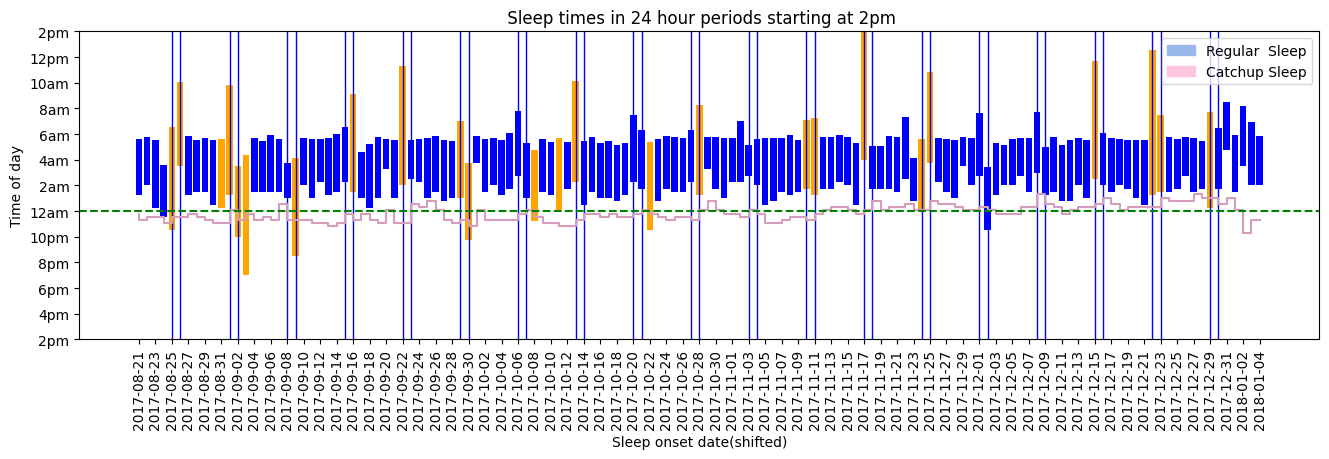

In [60]:

where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round_25'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round_25'],color=color_for_bars)
#         color='#9BB8ED')
axs.scatter(SleepingDates_naps,sleeping_48hour_naps, color='blue', marker='x',label='Nap onset(Btwn 11-15hrs,dur <3hr)')


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
for i in range(len(weekend)):
    if weekend[i]== 1:
        plt.axvline(x=SleepingDates_48hr['sleep_start_shift'].iloc[i],linewidth=1,color="blue")  

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")
# plt.set_xticklabels(date_list2)
plt.tick_params('x',rotation=90)
plt.title(" Sleep times in 24 hour periods starting at 2pm")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")


# dlmo_trunc = len(SleepingDates_48hr['start_time_num_round_25'])
EstimatedSleepOnset_phone = EstimatedSleepOnset #saving phone based sleep onset on another array
axs.step(SleepingDates_48hr_phone['sleep_start_shift'],EstimatedSleepOnset, 
         color='#D69CBC', where=where_type, label = "Predicted sleep onset-Phone")

axs.scatter(SleepingDates_naps,sleeping_48hour_naps, color='blue', marker='x',label='Nap onset(Btwn 11-15hrs,dur <3hr)')
axs.axhline(y=24, linestyle='dashed',color='green',label='midnight')


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color = '#9BB8ED',label = 'Regular  Sleep')
pink_patch = mpatches.Patch(color = '#FEC6DF',label = 'Catchup Sleep')
plt.legend(handles = [blue_patch, pink_patch],loc='upper right')


plt.show()

## adding activity usage

In [62]:
#        |--------------|
#     |-----------| ok
#                |-----------| ok
# |------------------------------|
#            |------| ok


selected_activity_streaks = []
_user_Activity = ActivityContInnings_df[(ActivityContInnings_df['user_id']== chosen_user) & 
                                                (ActivityContInnings_df['count']>7)]
_user_Activity = _user_Activity[~(_user_Activity['activity_streak_start_date'] > chosen_user_streak_end)]
_user_Activity = _user_Activity[~(_user_Activity['activity_streak_end_date'] < chosen_user_streak_start)]
_user_Activity = _user_Activity[['user_id','day_label','activity_streak_start_date','activity_streak_end_date',
                          'count']]

for i in range(len(_user_Activity)):
    if _user_Activity['activity_streak_start_date'].iloc[i]>= chosen_user_streak_start:
        if _user_Activity['activity_streak_end_date'].iloc[i] <= chosen_user_streak_end:
            selected_activity_streaks.append([_user_Activity['activity_streak_start_date'].iloc[i],
                                           _user_Activity['activity_streak_end_date'].iloc[i],
                                           _user_Activity['count'].iloc[i]])
        elif _user_Activity['activity_streak_end_date'].iloc[i] > chosen_user_streak_end:
 
            selected_activity_streaks.append([_user_Activity['activity_streak_start_date'].iloc[i],chosen_user_streak_end,
                                           (chosen_user_streak_end-_user_Activity['activity_streak_start_date'].iloc[i]).days])
    
    elif _user_Activity['activity_streak_start_date'].iloc[i] < chosen_user_streak_start:
        if _user_Activity['activity_streak_end_date'].iloc[i] <= chosen_user_streak_end:
            selected_activity_streaks.append([chosen_user_streak_start,_user_Activity['activity_streak_end_date'].iloc[i],
                                           (_user_Activity['activity_streak_end_date'].iloc[i]-chosen_user_streak_start).days])
        
        elif _user_Activity['activity_streak_end_date'].iloc[i] > chosen_user_streak_end:
            selected_activity_streaks.append([chosen_user_streak_start, chosen_user_streak_end,
                                           chosen_user_streak_length])
            
selected_activity_streaks_df = pd.DataFrame(selected_activity_streaks,columns=['activity_user_streak_start',
                                                                          'activity_user_streak_end','count'])         


selected_activity_streaks_df['user_id'] = chosen_user

selected_activity_streaks_df.sort_values(by='count',ascending=False,inplace=True)

activity_chosen_user_streak_start = selected_activity_streaks_df['activity_user_streak_start'].iloc[0]
activity_chosen_user_streak_end = selected_activity_streaks_df['activity_user_streak_end'].iloc[0]

print("activity streak: ","\nstart: ",activity_chosen_user_streak_start, "\nend  : ",activity_chosen_user_streak_end)

selected_activity_streaks_df.head()

activity streak:  
start:  2017-08-21 00:00:00 
end  :  2018-01-05 00:00:00


,activity_user_streak_start,activity_user_streak_end,count,user_id
0,2017-08-21,2018-01-05,137,1104


In [63]:
import math
vv = activity_sample[(activity_sample["user_id"]==chosen_user) &
                  (activity_sample["day_label_dt"]>=  activity_chosen_user_streak_start) &
                  (activity_sample["day_label_dt"] <=  activity_chosen_user_streak_end)]
vv = vv.reset_index()
vv.drop(columns={"index"},inplace=True)
'''rounding the start and end times of sleep to the nearest quarter for ease of calculation. will preserve
sleep duration calculation'''
vv['start_time_num_round_25'] = ((vv['start_time_num_round']%1)*100/60)+vv['start_time_num_round'].astype(int)
vv['start_time_num_round_25'] = round(vv['start_time_num_round_25']*4)/4
vv['start_time_num_round_25'] = np.where(((vv['start_time_num_round_25'] >= 23.45) &
                                          (vv['start_time_num_round_25'] < 24.0)), 
                                         23.75,vv['start_time_num_round_25'])

vv = vv[['day_label_dt','start_time_num_round_25','steps']].groupby(['day_label_dt','start_time_num_round_25']).sum().reset_index()

vv.rename(columns={'day_label_dt':'day_label'},inplace=True)
vv.head()

,day_label,start_time_num_round_25,steps
0,2017-08-21,0.25,48.0
1,2017-08-21,0.50,57.0
2,2017-08-21,1.00,194.0
3,2017-08-21,1.25,196.0
4,2017-08-21,5.75,60.0


In [64]:
first_date_activity_available= np.min(vv['day_label'])
last_date_activity_available= np.max(vv['day_label'])
print("min and max cut offs of activity data: ",first_date_activity_available," and ", last_date_activity_available)

min and max cut offs of activity data:  2017-08-21 00:00:00  and  2018-01-05 00:00:00


In [65]:
starting_date_vv = vv["day_label"].min()

starting_time_vv = vv.sort_values(by=["day_label","start_time_num_round_25"])["start_time_num_round_25"].values[0]

time_vals = np.arange(0.0, 23.75, 0.25)
time_vals = np.append(time_vals,23.75)

unique_dates = vv['day_label'].unique()
print("Initial unique dates length: ",len(unique_dates))
unique_dates = [x for x in unique_dates if x not in date_to_be_dropped]
print("Initial unique dates length: ",len(unique_dates))


import itertools
date_activity_combo =pd.DataFrame(list(itertools.product(np.unique(unique_dates),time_vals)))
date_activity_combo.columns = ["day_label", "start_time_num_round_25"]

date_activity_combo = date_activity_combo[date_activity_combo['day_label']<=last_date_activity_available]
print("number of days: ", len(date_activity_combo['day_label'].unique()),"\ntime vals: ", time_vals)

Initial unique dates length:  138
Initial unique dates length:  137
number of days:  137 
time vals:  [0.000000 0.250000 0.500000 0.750000 1.000000 1.250000 1.500000 1.750000
 2.000000 2.250000 2.500000 2.750000 3.000000 3.250000 3.500000 3.750000
 4.000000 4.250000 4.500000 4.750000 5.000000 5.250000 5.500000 5.750000
 6.000000 6.250000 6.500000 6.750000 7.000000 7.250000 7.500000 7.750000
 8.000000 8.250000 8.500000 8.750000 9.000000 9.250000 9.500000 9.750000
 10.000000 10.250000 10.500000 10.750000 11.000000 11.250000 11.500000
 11.750000 12.000000 12.250000 12.500000 12.750000 13.000000 13.250000
 13.500000 13.750000 14.000000 14.250000 14.500000 14.750000 15.000000
 15.250000 15.500000 15.750000 16.000000 16.250000 16.500000 16.750000
 17.000000 17.250000 17.500000 17.750000 18.000000 18.250000 18.500000
 18.750000 19.000000 19.250000 19.500000 19.750000 20.000000 20.250000
 20.500000 20.750000 21.000000 21.250000 21.500000 21.750000 22.000000
 22.250000 22.500000 22.750000 23.00

In [66]:
date_activity_combo = date_activity_combo.merge(vv[["day_label", "start_time_num_round_25","steps"]],
                                                how = 'left',
                                                left_on = ["day_label", "start_time_num_round_25"],
                                                right_on = ["day_label", "start_time_num_round_25"])
date_activity_combo['steps'] = date_activity_combo['steps'].fillna(0)

date_activity_combo= date_activity_combo.merge(date_sleep_combo,how='left', 
                                         left_on = ['day_label','start_time_num_round_25'],
                                        right_on = ['sleep_start','start_time_num_round_25'])
date_activity_combo['duration']=np.where(date_activity_combo['asleep_0_awake_300'] ==0,0,
                                     date_activity_combo['steps'])

date_activity_combo.drop(columns={'sleep_start','user_id','asleep_0_awake_300'},inplace=True)
date_activity_combo['day_label'] = date_activity_combo['day_label'].dt.date
print("number of rows: ",len(date_activity_combo))
date_activity_combo.head()

number of rows:  13152


,day_label,start_time_num_round_25,steps,duration
0,2017-08-21,0.00,0.0,0.0
1,2017-08-21,0.25,48.0,48.0
2,2017-08-21,0.50,57.0,57.0
3,2017-08-21,0.75,0.0,0.0
4,2017-08-21,1.00,194.0,194.0


Heatmap of activity in steps (Darker shades indicates activity)


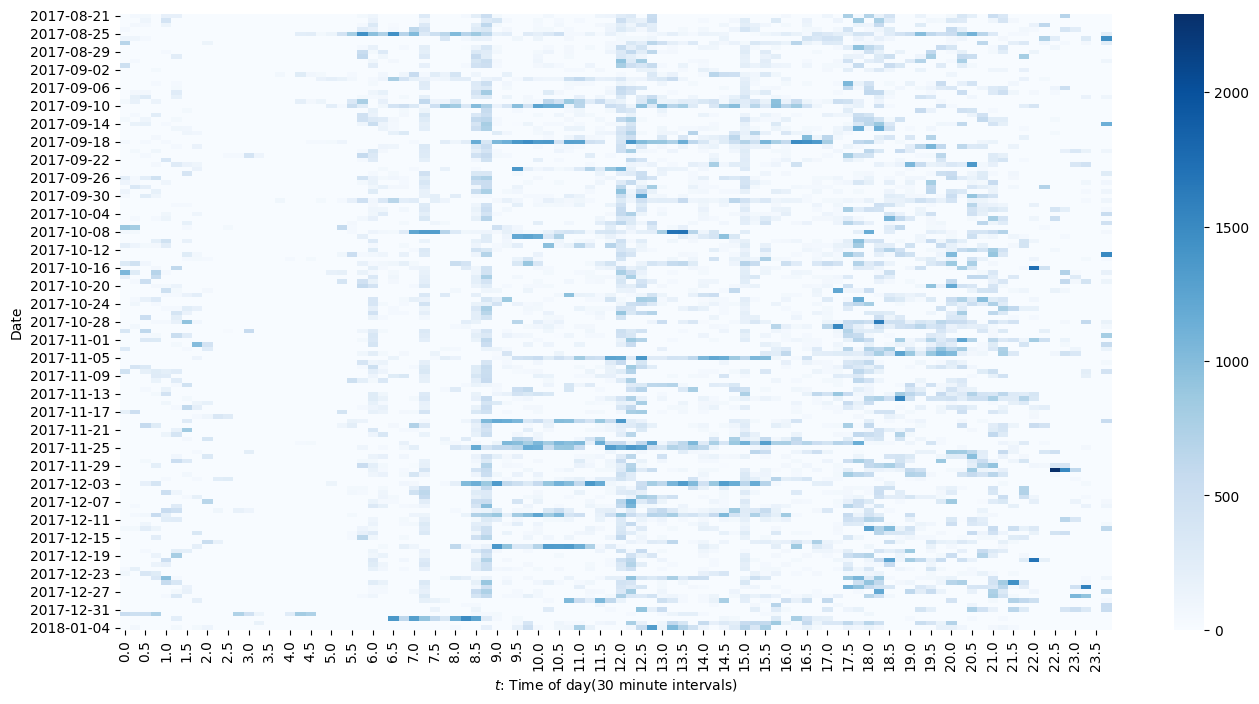

In [82]:
date_activity_combo_heatmap = pd.pivot_table(date_activity_combo,values='steps',
                                                       index='day_label',
                                                       columns='start_time_num_round_25')
import seaborn as sns
fig,axs = plt.subplots(figsize=(16,8))
sns.heatmap(date_activity_combo_heatmap,cmap='Blues',ax=axs)
# axs.vlines([25.0], *axs.get_xlim(),color='pink')
plt.xlabel("$t$: Time of day(30 minute intervals)")
plt.ylabel("Date")
# plt.title("Heatmap of activity in steps (Darker shades indicates activity)")
print("Heatmap of activity in steps (Darker shades indicates activity)")
plt.savefig("/file/out/antar/_user_1104_heatmap_activity_nonscaled.png",dpi=400)
plt.show()

In [68]:
# date_activity_combo['steps'] = date_activity_combo['steps']*10

In [69]:
activity_values = np.array(date_activity_combo["steps"])
print(type(phone_values),len(activity_values))
time_array = np.arange(0,len(activity_values))
activity_values

<class 'numpy.ndarray'> 13152


array([0.000000, 48.000000, 57.000000, ..., 0.000000, 0.000000, 0.000000])

In [70]:
import matplotlib.pyplot as plt

hr24marker = int(len(activity_values)/(24*4))
print("Whole days: ",hr24marker)


Whole days:  137


len of ts:  13152
n:  13152
[-0.300000 -1.130000 0.000000]
initial conditions: [-0.221358 -1.084267 0.059027]
cbts:  13152


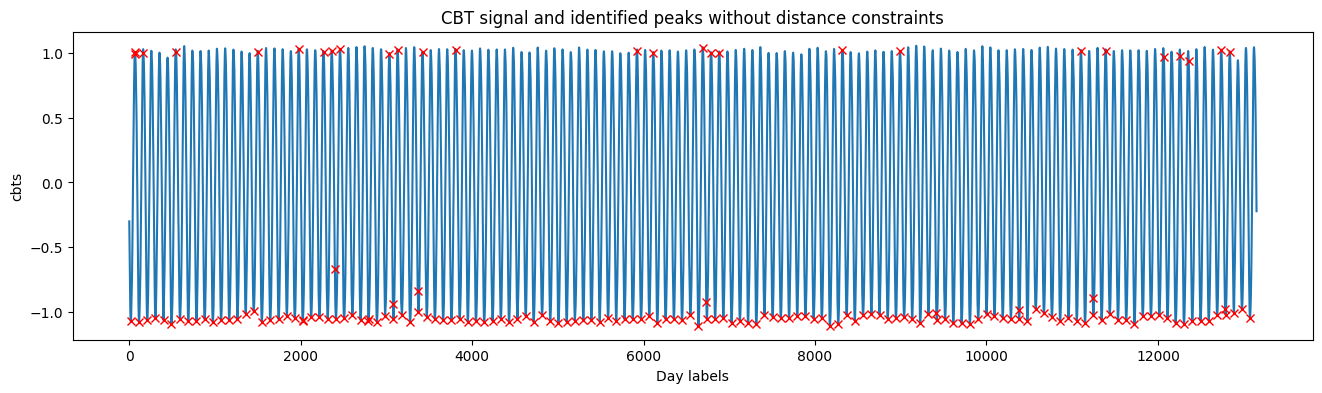

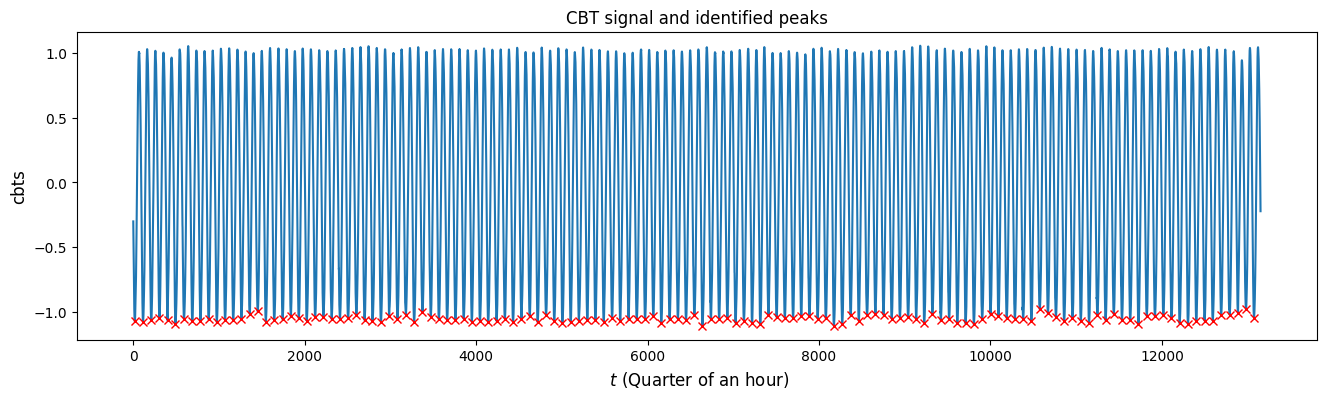

length cbt mins: (137,)
length of time array:  13152 length of dlmo:  137
137


In [71]:
ts = np.arange(0, 24*hr24marker, 0.25)
print("len of ts: ",len(ts))

initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=activity_values, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
print(len(dlmo_kj))
# for data in np.array(dlmo_kj):
#     print("{:9.2f}".format(data))

In [72]:
type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
print(dlmo_kj)

[-1.700000 22.300000 46.300000 70.050000 93.800000 116.800000 141.800000
 166.050000 189.800000 213.550000 237.300000 261.550000 285.300000
 309.300000 333.300000 356.800000 380.300000 405.050000 429.300000
 453.550000 476.550000 499.800000 524.300000 548.300000 572.300000
 596.550000 620.550000 644.300000 668.300000 691.300000 716.050000
 740.050000 764.300000 788.800000 812.800000 837.300000 861.300000
 885.050000 909.300000 933.300000 957.550000 981.300000 1004.800000
 1029.050000 1053.300000 1077.550000 1101.300000 1125.800000 1150.050000
 1173.050000 1197.800000 1221.550000 1245.300000 1269.550000 1293.550000
 1318.050000 1341.550000 1365.800000 1390.300000 1414.050000 1438.300000
 1462.050000 1486.550000 1510.550000 1533.800000 1557.800000 1582.050000
 1605.800000 1630.300000 1653.800000 1678.550000 1702.550000 1726.550000
 1750.300000 1774.800000 1798.550000 1822.550000 1846.300000 1870.050000
 1894.050000 1918.050000 1942.050000 1965.800000 1989.550000 2013.550000
 2037.050000 

In [73]:
dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))

[22.300000 22.300000 22.300000 22.050000 21.800000 20.800000 21.800000
 22.050000 21.800000 21.550000 21.300000 21.550000 21.300000 21.300000
 21.300000 20.800000 20.300000 21.050000 21.300000 21.550000 20.550000
 19.800000 20.300000 20.300000 20.300000 20.550000 20.550000 20.300000
 20.300000 19.300000 20.050000 20.050000 20.300000 20.800000 20.800000
 21.300000 21.300000 21.050000 21.300000 21.300000 21.550000 21.300000
 20.800000 21.050000 21.300000 21.550000 21.300000 21.800000 22.050000
 21.050000 21.800000 21.550000 21.300000 21.550000 21.550000 22.050000
 21.550000 21.800000 22.300000 22.050000 22.300000 22.050000 22.550000
 22.550000 21.800000 21.800000 22.050000 21.800000 22.300000 21.800000
 22.550000 22.550000 22.550000 22.300000 22.800000 22.550000 22.550000
 22.300000 22.050000 22.050000 22.050000 22.050000 21.800000 21.550000
 21.550000 21.050000 21.300000 22.050000 21.800000 22.050000 22.300000
 22.050000 21.800000 21.800000 21.550000 21.300000 20.550000 20.550000
 21.05

In [74]:
def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes


SleepingDates_48hr_activity = SleepingDates_48hr[(SleepingDates_48hr['sleep_start']>=first_date_activity_available) & 
                                              (SleepingDates_48hr['sleep_start']<=last_date_activity_available)]

# if date_to_be_dropped != None:
#     SleepingDates_48hr_activity = SleepingDates_48hr[(SleepingDates_48hr['sleep_start']>date_to_be_dropped) & 
#                                               (SleepingDates_48hr['sleep_start']>=first_date_activity_available) & 
#                                               (SleepingDates_48hr['sleep_start']<=last_date_activity_available)]
# else:
#     SleepingDates_48hr_activity = SleepingDates_48hr[(SleepingDates_48hr['sleep_start']>=first_date_activity_available) & 
#                                               (SleepingDates_48hr['sleep_start']<=last_date_activity_available)]   

import matplotlib.ticker as ticker

sleep_48hr = list(SleepingDates_48hr_activity['start_time_num_round_25'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []
for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+12.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_Activity = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_Activity.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_Activity.append(None)
        
for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr_activity['sleep_start_shift'].dt.date), 
                                                          np.array(SleepingDates_48hr_activity['start_time_num_round_25']),
                                                          EstimatedSleepOnset,
                                               MinutesBetweenPredictedAndActualSleep_Activity):
    print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, 
          "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    


sleep date: 2017-08-21 Actual sleep time: 25.25 Estimated sleep time:  24.3 Minutes in between:  -57.0
sleep date: 2017-08-22 Actual sleep time: 26.0 Estimated sleep time:  24.3 Minutes in between:  -102.0
sleep date: 2017-08-23 Actual sleep time: 24.25 Estimated sleep time:  24.3 Minutes in between:  3.0
sleep date: 2017-08-24 Actual sleep time: 23.5 Estimated sleep time:  24.05 Minutes in between:  33.0
sleep date: 2017-08-25 Actual sleep time: 22.5 Estimated sleep time:  23.8 Minutes in between:  78.0
sleep date: 2017-08-26 Actual sleep time: 27.5 Estimated sleep time:  22.8 Minutes in between:  -282.0
sleep date: 2017-08-27 Actual sleep time: 25.25 Estimated sleep time:  23.8 Minutes in between:  -87.0
sleep date: 2017-08-28 Actual sleep time: 25.5 Estimated sleep time:  24.05 Minutes in between:  -87.0
sleep date: 2017-08-29 Actual sleep time: 25.5 Estimated sleep time:  23.8 Minutes in between:  -102.0
sleep date: 2017-08-30 Actual sleep time: 24.5 Estimated sleep time:  23.55 Mi

In [75]:
print(len(SleepingDates_48hr_activity['sleep_start_shift']),len(SleepingDates_48hr_activity['start_time_num_round_25']),
     len(EstimatedSleepOnset),len(dlmo_kj2))

137 137 137 137


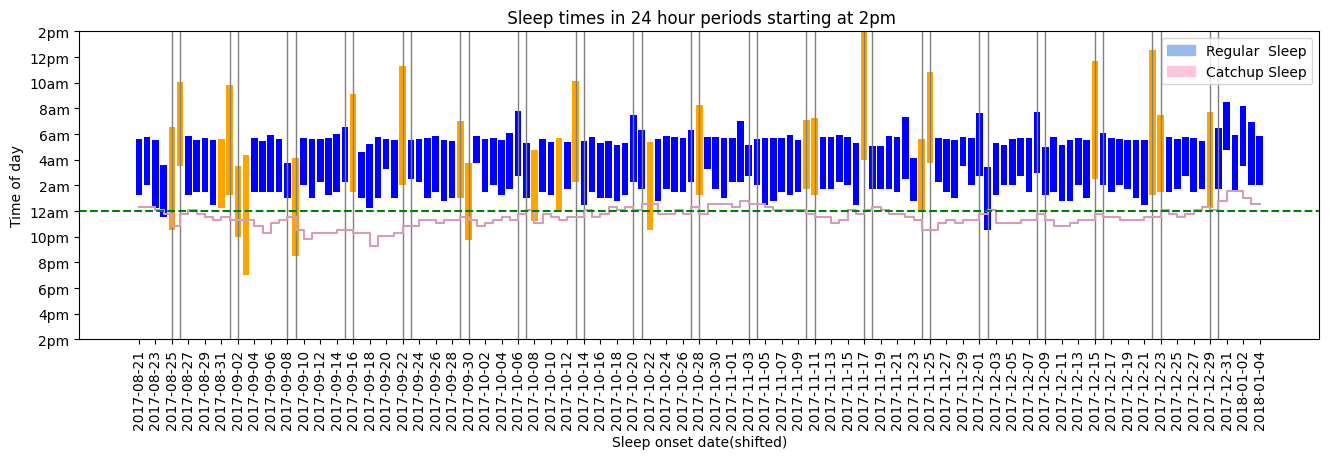

In [76]:
where_type = "pre"

fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round_25'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round_25'],color=color_for_bars)
#         color='#9BB8ED')
axs.scatter(SleepingDates_naps,sleeping_48hour_naps, color='blue', marker='x',label='Nap onset(Btwn 11-15hrs,dur <3hr)')


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
for i in range(len(weekend)):
    if weekend[i]== 1:
        plt.axvline(x=SleepingDates_48hr['sleep_start_shift'].iloc[i],linewidth=1,color="grey")  

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")
# plt.set_xticklabels(date_list2)
plt.tick_params('x',rotation=90)
plt.title(" Sleep times in 24 hour periods starting at 2pm")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")


# dlmo_trunc = len(SleepingDates_48hr['start_time_num_round_25'])
EstimatedSleepOnset_activity = EstimatedSleepOnset # saving predicted sleep in another array
axs.step(SleepingDates_48hr_activity['sleep_start_shift'],EstimatedSleepOnset, 
         color='#D69CBC', where=where_type, label = "Predicted sleep onset - Activity")

axs.scatter(SleepingDates_naps,sleeping_48hour_naps, color='blue', marker='x',label='Nap onset(Btwn 11-15hrs,dur <3hr)')
axs.axhline(y=24, linestyle='dashed',color='green',label='midnight')


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color = '#9BB8ED',label = 'Regular  Sleep')
pink_patch = mpatches.Patch(color = '#FEC6DF',label = 'Catchup Sleep')
plt.legend(handles = [blue_patch, pink_patch],loc='upper right')


plt.show()

# Consolidating estimated sleep predictions from sleep wake, phone usage and activity

dates list 137
dates list 137
dates list 137


/tmp/ipykernel_3978959/1428757667.py:75: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if list(SleepingDates).index(s)%set_interval == 0:


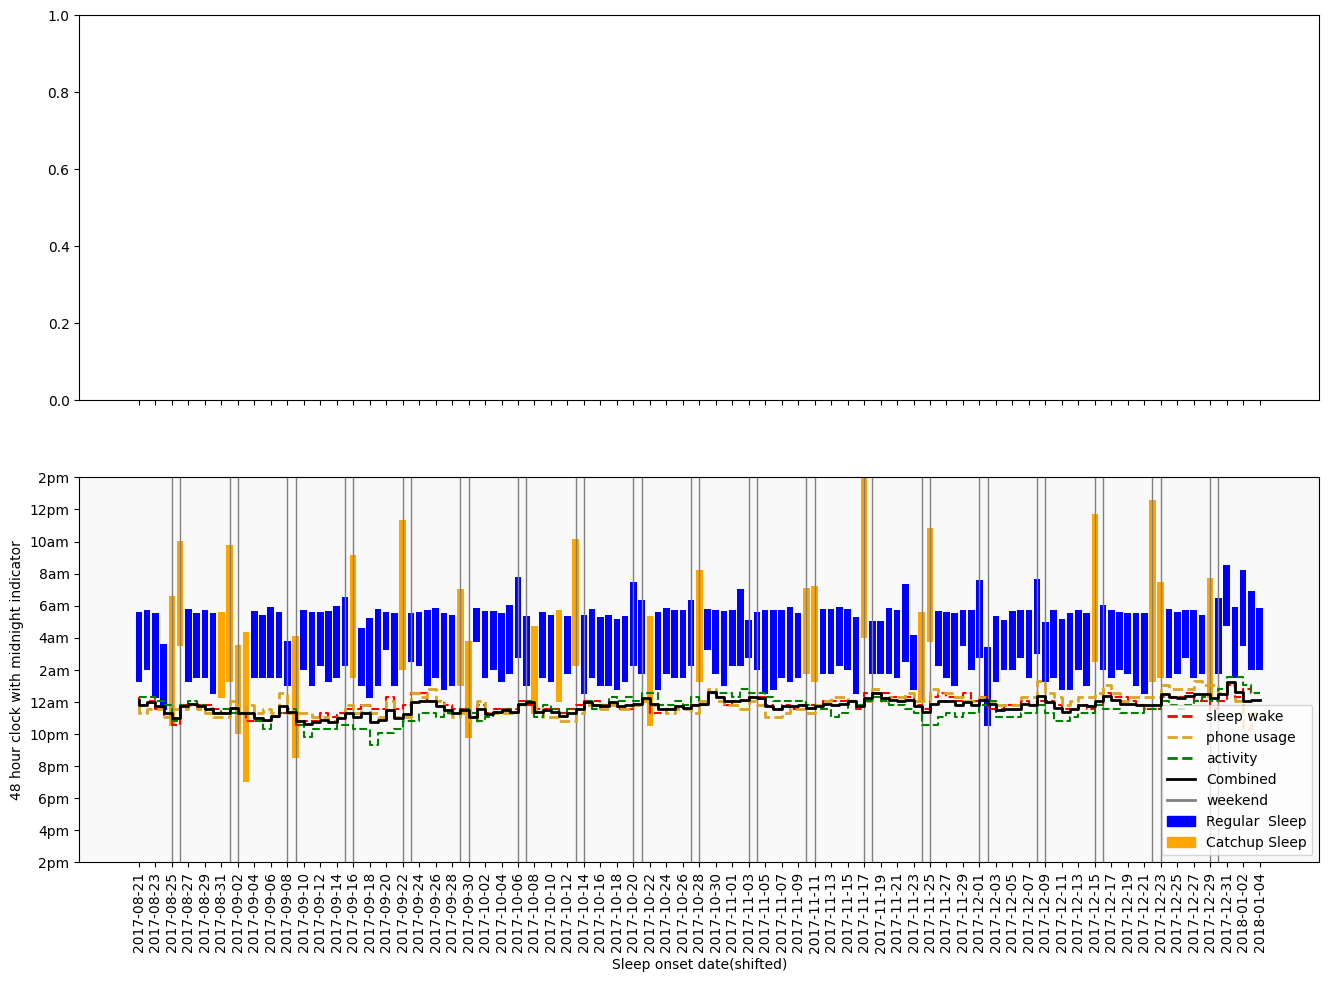

In [84]:
window_size= 14

def calculate_sleep_deficit(MinutesBetweenPredictedAndActualSleep,
                            window_size,
                            SleepingDates_48hr):
    date_list = list(SleepingDates_48hr['sleep_start_shift'])
    print("dates list",len(date_list))
    MinutesBetweenPredictedAndActualSleep = [x if x is not None else 0 for x in MinutesBetweenPredictedAndActualSleep]
    
    net_sleep_surplus = []
    reverse_dates = []
    for i in range(len(MinutesBetweenPredictedAndActualSleep)):
#         print("i: ",i)
        if i == len(MinutesBetweenPredictedAndActualSleep)-window_size+1:
            break
        _var = 0
        j = 0
        while j < 14:
            _var+=MinutesBetweenPredictedAndActualSleep[i+j]
            j+=1
        net_sleep_surplus.append(_var)
        reverse_dates.append(date_list[i+window_size-1])
    return net_sleep_surplus,reverse_dates
    

net_sleep_surplus_sleepwake, reverse_dates_sleepwake = calculate_sleep_deficit(MinutesBetweenPredictedAndActualSleep_sleepwake,
                                                                     14,SleepingDates_48hr)
net_sleep_surplus_activity, reverse_dates_activity = calculate_sleep_deficit(MinutesBetweenPredictedAndActualSleep_Activity,
                                                                    14,SleepingDates_48hr_activity)
net_sleep_surplus_phone, reverse_dates_phone = calculate_sleep_deficit(MinutesBetweenPredictedAndActualSleep_phone,
                                                                 14, SleepingDates_48hr_phone)

r_list2 = []
for s in reverse_dates_sleepwake:
    if list(reverse_dates_sleepwake).index(s)%set_interval == 0:
        r_list2.append(s)

fig, axs = plt.subplots(2,1,figsize=(16,11),sharex=True)
# axs[0].set_xticks(date_list2)
# axs[0].plot(reverse_dates_sleepwake, net_sleep_surplus_sleepwake,color='red',label='sleep wake')
# axs[0].plot(reverse_dates_phone, net_sleep_surplus_phone,color='blue', label = 'phone usage')
# axs[0].plot(reverse_dates_activity, net_sleep_surplus_activity,color='green', label = 'activity')


# axs[0].grid(color='0.95')
   
# axs[0].set_xlabel("Sleep Onset date (shifted)")
# axs[0].set_ylabel("Net Sleep Surplus in minutes")
# axs[0].tick_params('x',rotation=90)
# title_txt = str(window_size) +" day rolling sums of net sleep surplus"
# axs[0].set_title(title_txt)
# axs[0].legend()

EstimatedSleepOnset_SW_Ph_Act = []
for i in range(len(EstimatedSleepOnset_SleepWake)):
    EstimatedSleepOnset_SW_Ph_Act.append(np.round((EstimatedSleepOnset_SleepWake[i]+EstimatedSleepOnset_phone[i]+
                                        EstimatedSleepOnset_activity[i])/3,2))


# print(EstimatedSleepOnset_SW_Ph_Act)
where_type = "pre"
axs[1].set_ylim(14,38)
axs[1].set_yticks(np.arange(14,40,2))
axs[1].set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs[1].bar(SleepingDates_48hr['sleep_start_shift'].dt.date,SleepingDates_48hr['start_time_num_round_25'],
           color='#f9f9f9')
axs[1].bar(SleepingDates_48hr['sleep_start_shift'].dt.date,SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round_25'],color=color_for_bars)



set_interval = 2
date_list2 = []
for s in SleepingDates.dt.date:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
for i in range(len(weekend)):
    if weekend[i]== 1:
        axs[1].axvline(x=SleepingDates_48hr['sleep_start_shift'].iloc[i],linewidth=1,color="grey")  

axs[1].set_xticks(date_list2)
axs[1].tick_params(axis='x',rotation=90)      
axs[1].set_xticklabels(date_list2)
axs[1].tick_params('x',rotation=90)
# axs[1].set_title(" Sleep times in 24 hour periods starting at 2pm")
axs[1].set_xlabel("Sleep onset date(shifted)")
axs[1].set_ylabel("48 hour clock with midnight indicator")


# dlmo_trunc = len(SleepingDates_48hr['start_time_num_round_25'])
axs[1].step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset_SleepWake, 
         color='red',linestyle='--', where=where_type, label = "Predicted sleep onset - sleep wake")

axs[1].step(SleepingDates_48hr_phone['sleep_start_shift'],EstimatedSleepOnset_phone, 
         color='#DAA520',lw=2,linestyle='--', where=where_type, label = "Predicted sleep onset - Phone")

axs[1].step(SleepingDates_48hr_activity['sleep_start_shift'],EstimatedSleepOnset_activity, 
         color='green',linestyle='--' ,where=where_type, label = "Predicted sleep onset - Activity")

axs[1].step(SleepingDates_48hr_activity['sleep_start_shift'],EstimatedSleepOnset_SW_Ph_Act, lw=2,
            color='black', where=where_type, label = "Predicted sleep onset - Averaged")

axs[1].set_facecolor("#f9f9f9")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
blue_patch = Patch(color = 'blue',label = 'Regular  Sleep')
pink_patch = Patch(color = 'orange',label = 'Catchup Sleep')
custom_legends = [Line2D([0],[0],color='red',lw=2,linestyle='--',label='sleep wake'),
                  Line2D([0],[0],color='#DAA520',lw=2,linestyle = '--',label='phone usage'),
                  Line2D([0],[0],color='green',lw=2,linestyle = '--',label='activity'),
                  Line2D([0],[0],color='black',lw=2,label='Combined'),
                  Line2D([0],[0],color='grey',lw=2,label='weekend'),blue_patch,pink_patch] 
plt.legend(handles = custom_legends,loc='lower right')

plt.savefig("/file/out/antar/1104_3models.png",dpi=400)
plt.show()